In [1]:
import os
import numpy as np
import pandas as pd
from scipy import sparse
import anndata

import matplotlib.pyplot as plt
import seaborn as sns

import importlib
from scroutines import basicu
importlib.reload(basicu)
from scroutines.config_plots import *

In [2]:
def counts_to_bulk_profiles(mat, types):
    """
    mat: cell by genes (all genes)
    
    """
    Xk, xclsts = basicu.group_sum(mat, types)
    Xkcov = np.asarray(Xk.sum(axis=1))#.reshape(-1,)
    cpm = Xk/Xkcov*1e6
    logcpm = np.log10(cpm+1)
    return xclsts, Xk, cpm, logcpm

# get data

In [3]:
ddir = '../data/cheng21_cell_scrna/organized/'
files = [
    'P8NR.h5ad',
    'P14NR.h5ad',
    'P17NR.h5ad',
    'P21NR.h5ad',
    'P28NR.h5ad',
    'P38NR.h5ad',
] 

In [4]:
pbulks = []
xclsts = []
for f in files:
    print(f)
    
    path = os.path.join(ddir, f)
    adata = anndata.read(path)
    genes = adata.var.index.values
    
    mat = adata.X
    types = adata.obs['Subclass'].astype(str).values 
    # 1 or 2
    sample_codes = adata.obs['sample'].apply(lambda x: x.split('_')[1][:-1].replace('3', '2')).astype(str).values
    sample_and_type = sample_codes + "_" + types
    _xclsts, Xk, Xk_n, Xk_ln = counts_to_bulk_profiles(mat, sample_and_type) 
    
    # check all types + reps are the same
    if len(xclsts) > 0:
        if not np.all(_xclsts == xclsts):
            raise ValueError(_xclsts.shape, xclsts.shape, _xclsts, xclsts,)
    else:
        xclsts = _xclsts
        print(xclsts)
        
    print(Xk_ln.shape)
    pbulks.append(Xk_ln)
    
pbulks = np.array(pbulks)
print(pbulks.shape)
pbulks = pbulks.reshape(6,2,20,-1)
xclsts = xclsts.reshape(2,20)
print(pbulks.shape)

P8NR.h5ad
['1_Astro' '1_Endo' '1_Frem1' '1_L2/3' '1_L4' '1_L5IT' '1_L5NP' '1_L5PT'
 '1_L6CT' '1_L6IT' '1_L6b' '1_Lamp5' '1_Micro' '1_OD' '1_OPC' '1_Pvalb'
 '1_Sst' '1_Stac' '1_VLMC' '1_Vip' '2_Astro' '2_Endo' '2_Frem1' '2_L2/3'
 '2_L4' '2_L5IT' '2_L5NP' '2_L5PT' '2_L6CT' '2_L6IT' '2_L6b' '2_Lamp5'
 '2_Micro' '2_OD' '2_OPC' '2_Pvalb' '2_Sst' '2_Stac' '2_VLMC' '2_Vip']
(40, 53801)
P14NR.h5ad
(40, 53801)
P17NR.h5ad
(40, 53801)
P21NR.h5ad
(40, 53801)
P28NR.h5ad
(40, 53801)
P38NR.h5ad
(40, 53801)
(6, 40, 53801)
(6, 2, 20, 53801)


In [5]:
# a = pbulks
# b = pbulks.reshape(6,2,20,-1)
# print(a.shape, b.shape)

# assert np.all(a[:,0,:] == b[:,0,0,:])
# assert np.all(a[:,1,:] == b[:,0,1,:])
# assert np.all(a[:,2,:] == b[:,0,2,:])
# assert np.all(a[:,19,:] == b[:,0,19,:])
# assert np.all(a[:,20,:] == b[:,1,0,:])

In [6]:
xclsts_short = np.array([clst[len("1_"):] for clst in xclsts[0]]) #, '_')
xclsts_short

array(['Astro', 'Endo', 'Frem1', 'L2/3', 'L4', 'L5IT', 'L5NP', 'L5PT',
       'L6CT', 'L6IT', 'L6b', 'Lamp5', 'Micro', 'OD', 'OPC', 'Pvalb',
       'Sst', 'Stac', 'VLMC', 'Vip'], dtype='<U5')

# do this better
- each gene in each cell type has 12 numbers: 6 time points * 2 bio-replicates per time point
- find the genes that are dynamic means they have high variance and high variance ratio explained by time points

In [7]:
# scale this up (for each cell type and each gene)
def get_eta2(nums):
    """
    nums: 6,2 matrix - 6 time points and 2 replicates
    """
    nums_m  = np.mean(nums)
    nums_rm = np.mean(nums, axis=1)

    # SSt 
    SSt = np.linalg.norm(nums-nums_m, ord='fro')**2

    # SSw
    SSw = np.linalg.norm(nums-nums_rm.reshape(-1,1), ord='fro')**2

    eta2 = (1-(SSw+1e-6)/(SSt+1e-6))
    return eta2

def get_eta2_allgenes(nums):
    """
    nums: 6,2,n matrix - 6 time points by 2 replicates by n genes
    
    return (eta2, stdv) - vectors one entry for each gene
    """
    nt, nr, ng = nums.shape # (num time points, num rep, num genes)
    # print(nt, nr, ng)

    nums_m  = np.mean(nums, axis=(0,1)) # one for each gene (2) across time points and replicates (0,1)
    nums_rm = np.mean(nums, axis=1) # one for each gene (2) and time-point (1) across replicates (1)
    # print(nums_m.shape, nums_rm.shape)

    # # SSt 
    SSt = np.sum(np.power((nums - np.expand_dims(nums_m , axis=(0,1))), 2), axis=(0,1))  # one for each gene

    # # SSw
    SSw = np.sum(np.power((nums - np.expand_dims(nums_rm, axis=(1  ))), 2), axis=(0,1))  # one for each gene

    eta2 = (1-(SSw+1e-6)/(SSt+1e-6))
    stdb = np.sqrt((SSt-SSw)/(nt*nr))
    return eta2, stdb

# nums = pbulks[:,:2,0]
# nums.shape, get_eta2(nums)

# nums = pbulks[:,:2,:]
# eta2, stdb = get_eta2_allgenes(nums)
# eta2.shape, stdb.shape

In [8]:
def merge_first_few_dims(mat):
    """Keep last dim
    """
    return mat.reshape(-1,mat.shape[-1])

# a = pb1csub.reshape(-1,pb1csub.shape[-1])
# a[:,1] # pb1csub[:,:,1]

In [9]:
xclsts_sel = [
    'L2/3', 'L4', 'L5IT', 'L6IT', 
    'L5PT', 'L6CT', 'L5NP', 'L6b',
]
xclsts_selidx = basicu.get_index_from_array(xclsts_short, xclsts_sel)
xclsts_selidx

array([ 3,  4,  5,  9,  7,  8,  6, 10])

In [10]:
pbulks = pbulks[:,:,xclsts_selidx,:]
nt, nr, nc, ng = pbulks.shape
nt, nr, nc, ng

(6, 2, 8, 53801)

In [11]:
maxexp = np.max(np.mean(pbulks, axis=1), axis=0) 
maxexp.shape

(8, 53801)

In [12]:
eta2, stdb = get_eta2_allgenes(pbulks.reshape(nt, nr, -1))
eta2 = eta2.reshape(nc, ng)
stdb = stdb.reshape(nc, ng)
eta2.shape, stdb.shape

((8, 53801), (8, 53801))

# Overview
- all genes and all cell types (n=8 Glut. subclasses)

In [13]:
np.log10(1+1), np.log10(10+1), np.log10(20+1), np.log10(50+1),

(0.3010299956639812, 1.041392685158225, 1.3222192947339193, 1.7075701760979363)

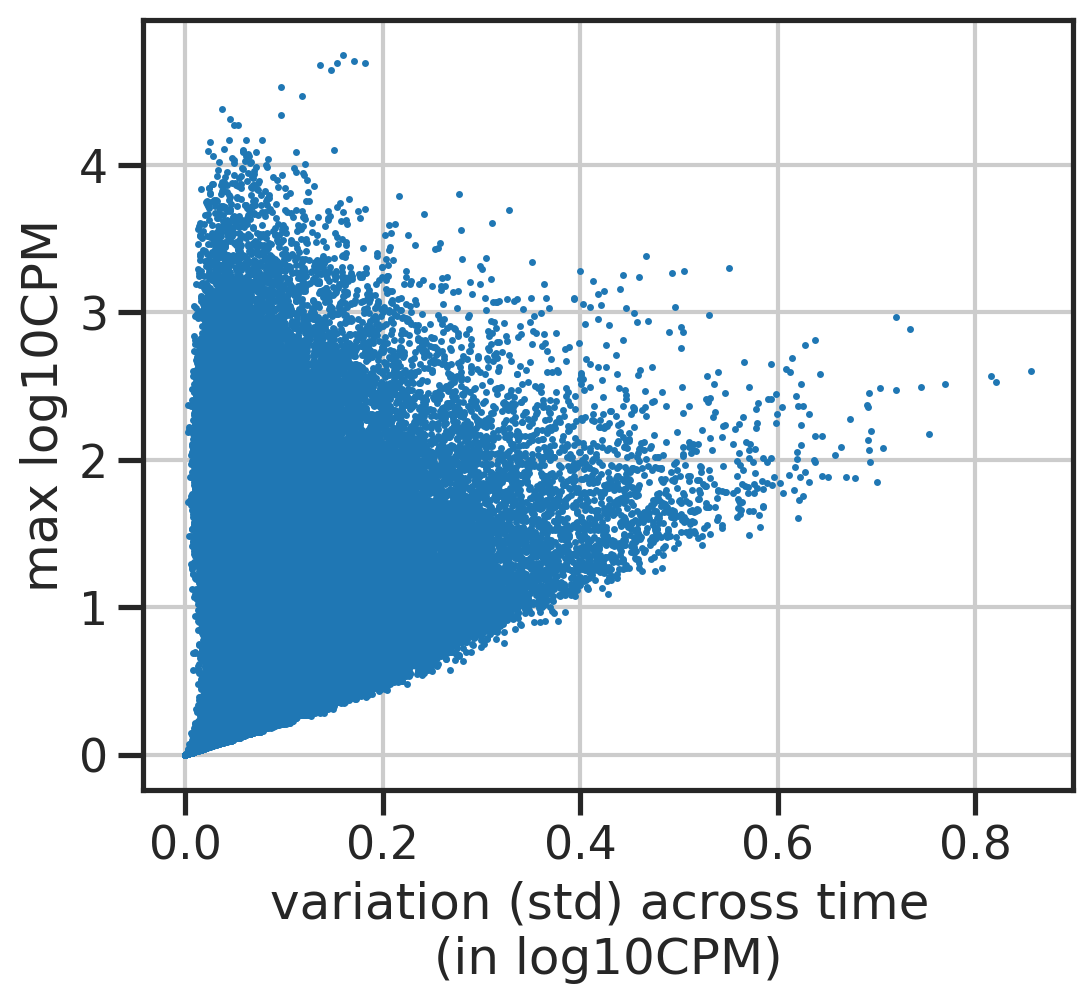

In [14]:
fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(stdb.ravel(), maxexp.ravel(), s=1)
ax.set_xlabel('variation (std) across time \n(in log10CPM)')
ax.set_ylabel('max log10CPM')
plt.show()

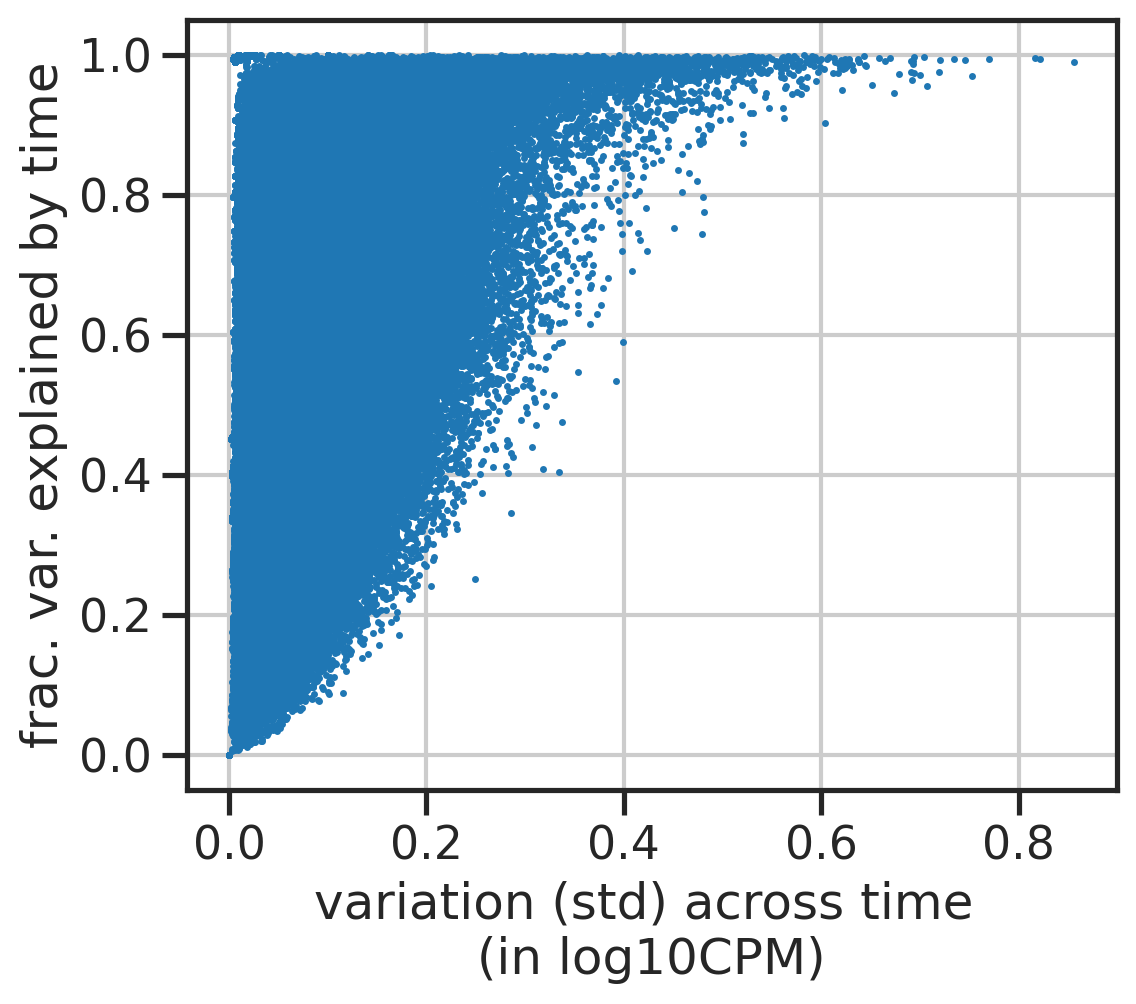

In [15]:
fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(stdb.ravel(), eta2.ravel(), s=1)
ax.set_xlabel('variation (std) across time \n(in log10CPM)')
ax.set_ylabel('frac. var. explained by time')
plt.show()

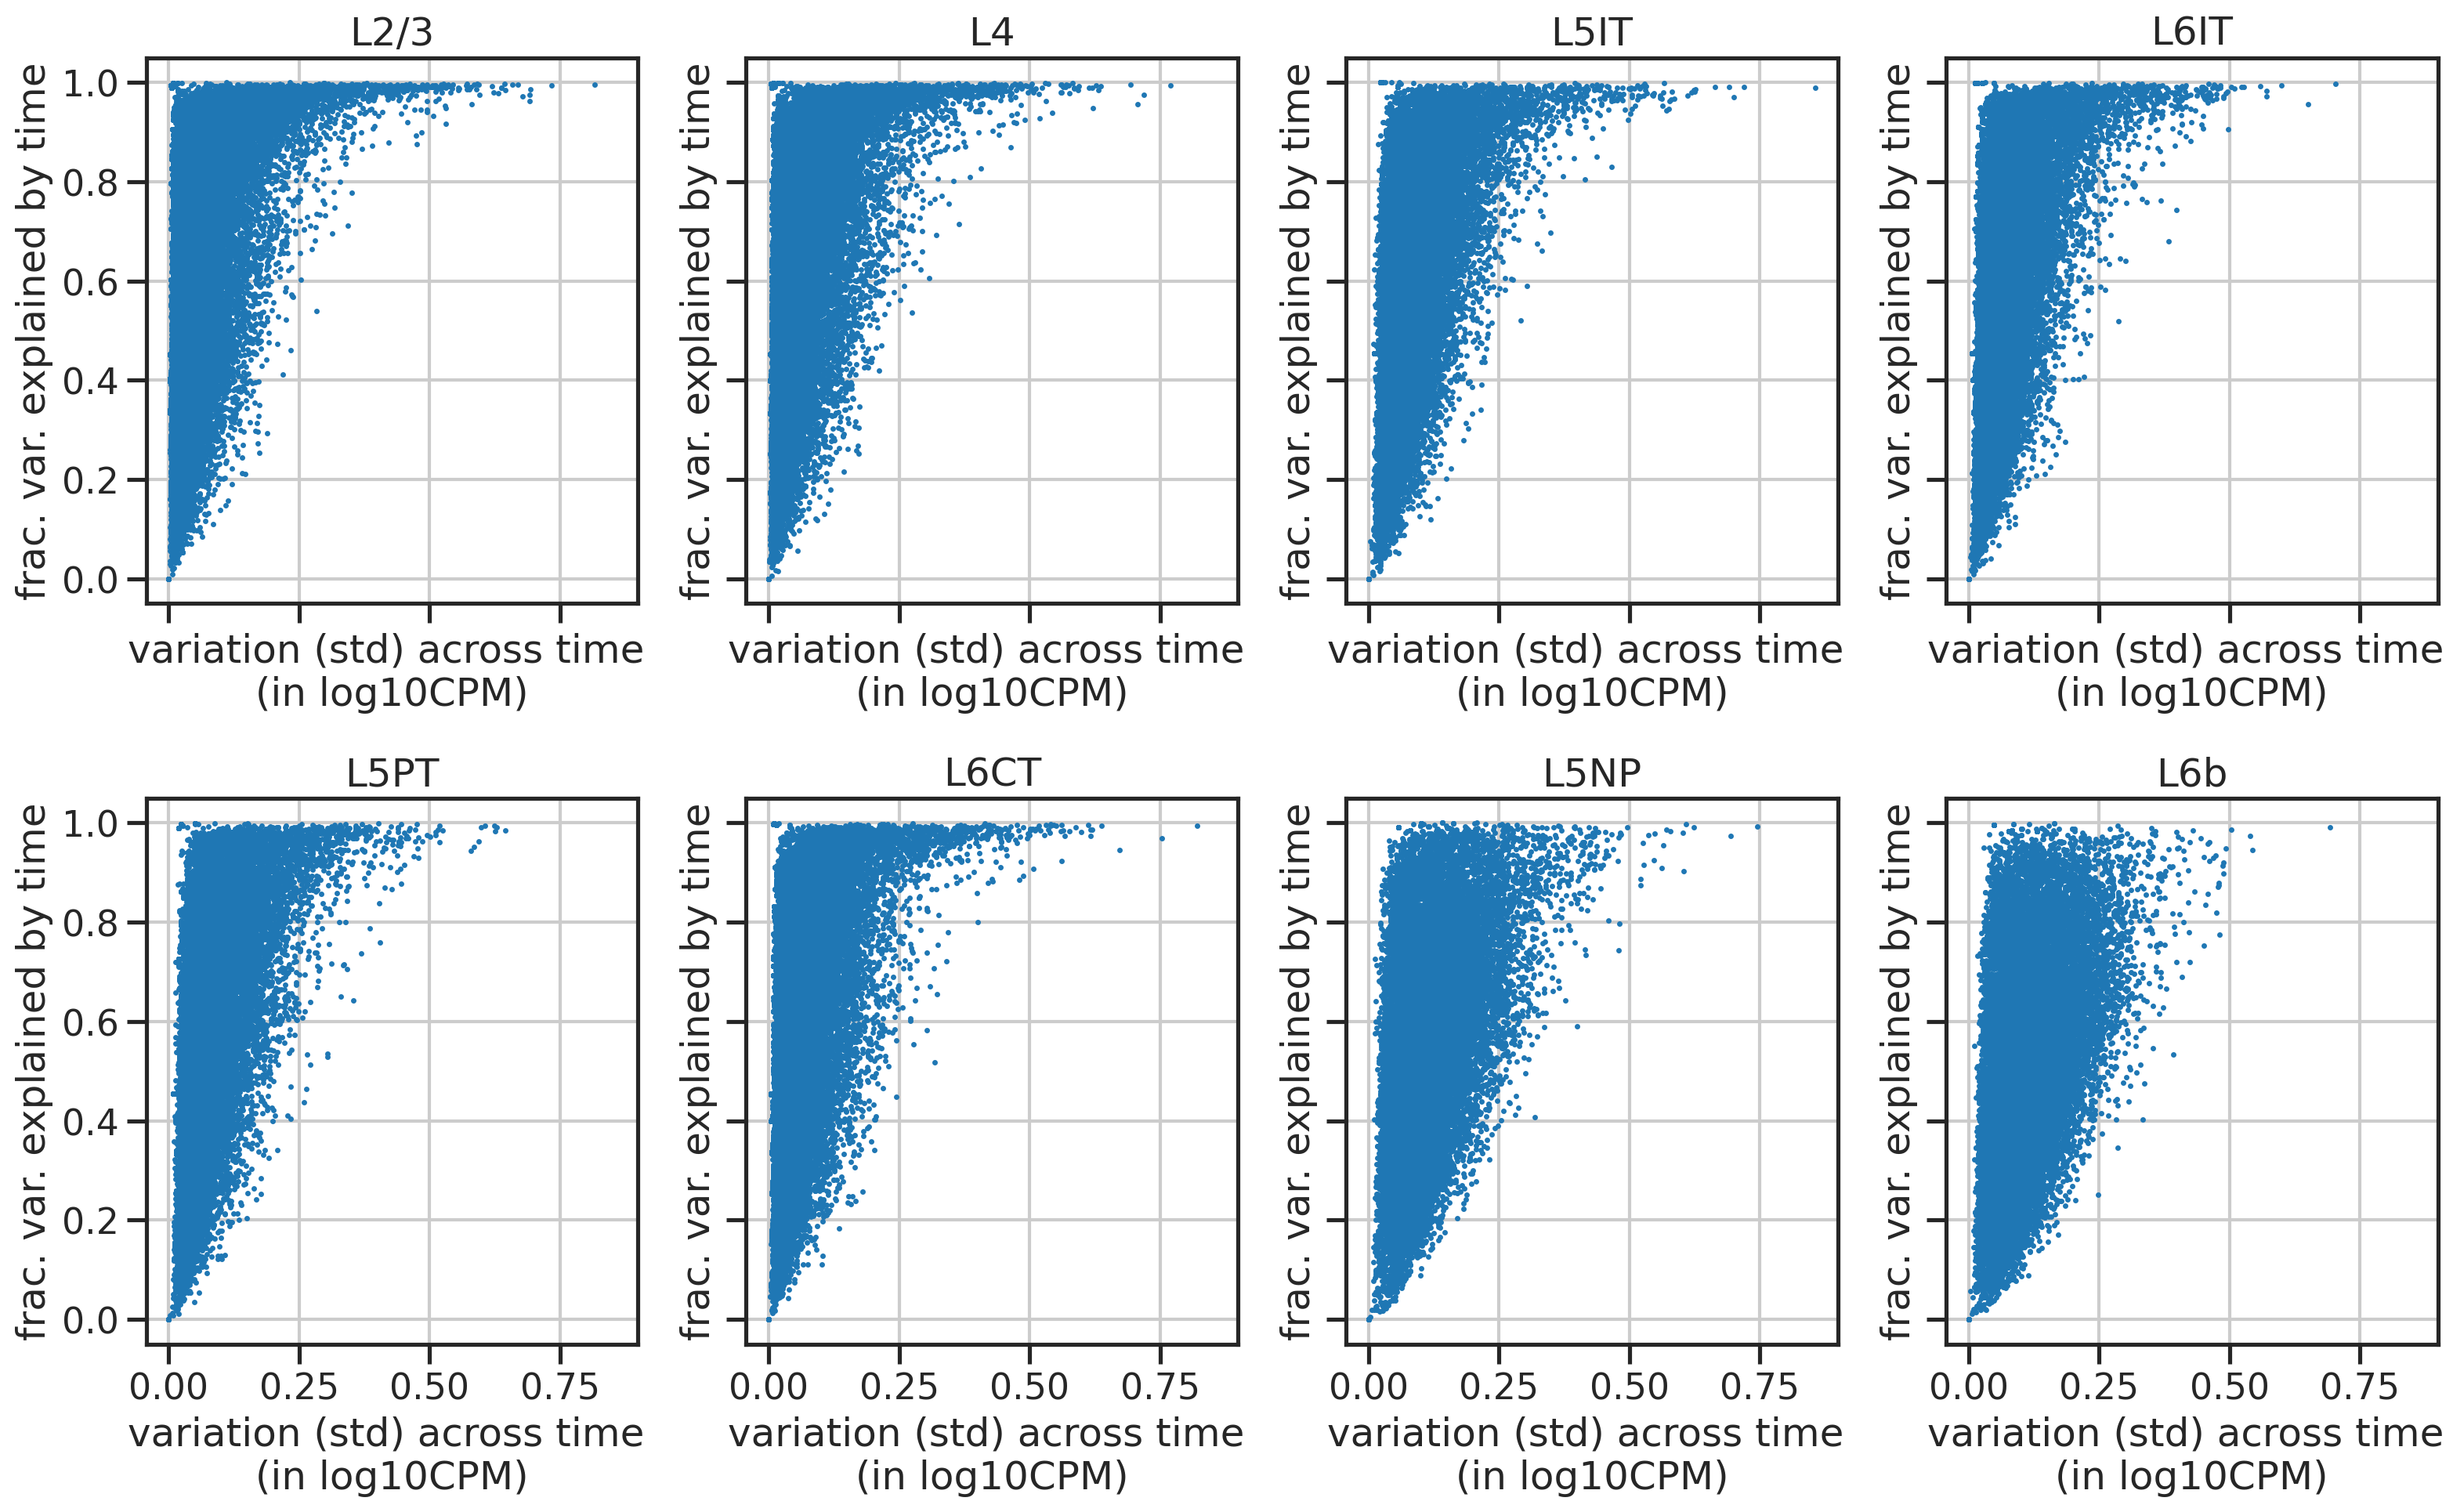

In [16]:
fig, axs = plt.subplots(2,4,figsize=(4*4,5*2), sharex=True, sharey=True)
for i, ax in enumerate(axs.flat):
    ax.scatter(stdb[i], eta2[i], s=1)
    ax.set_title(xclsts_sel[i])
    ax.set_xlabel('variation (std) across time \n(in log10CPM)')
    ax.set_ylabel('frac. var. explained by time')
fig.tight_layout()
plt.show()

In [17]:
10**0.4

2.51188643150958

In [18]:
hits   = np.all(np.array([stdb>0.4, eta2>0.8, maxexp>1.3]), axis=0) #np.logical_and((stdb > 0.4), (eta2>0.8))
g_hits = np.sum(hits, axis=0)
c_hits = np.sum(hits, axis=1)
print(np.sum(hits))
print((c_hits >= 1).sum(), np.max(c_hits))
print((g_hits >= 1).sum(), (g_hits == 1).sum(), np.max(g_hits))

739
8 159
371 197 8


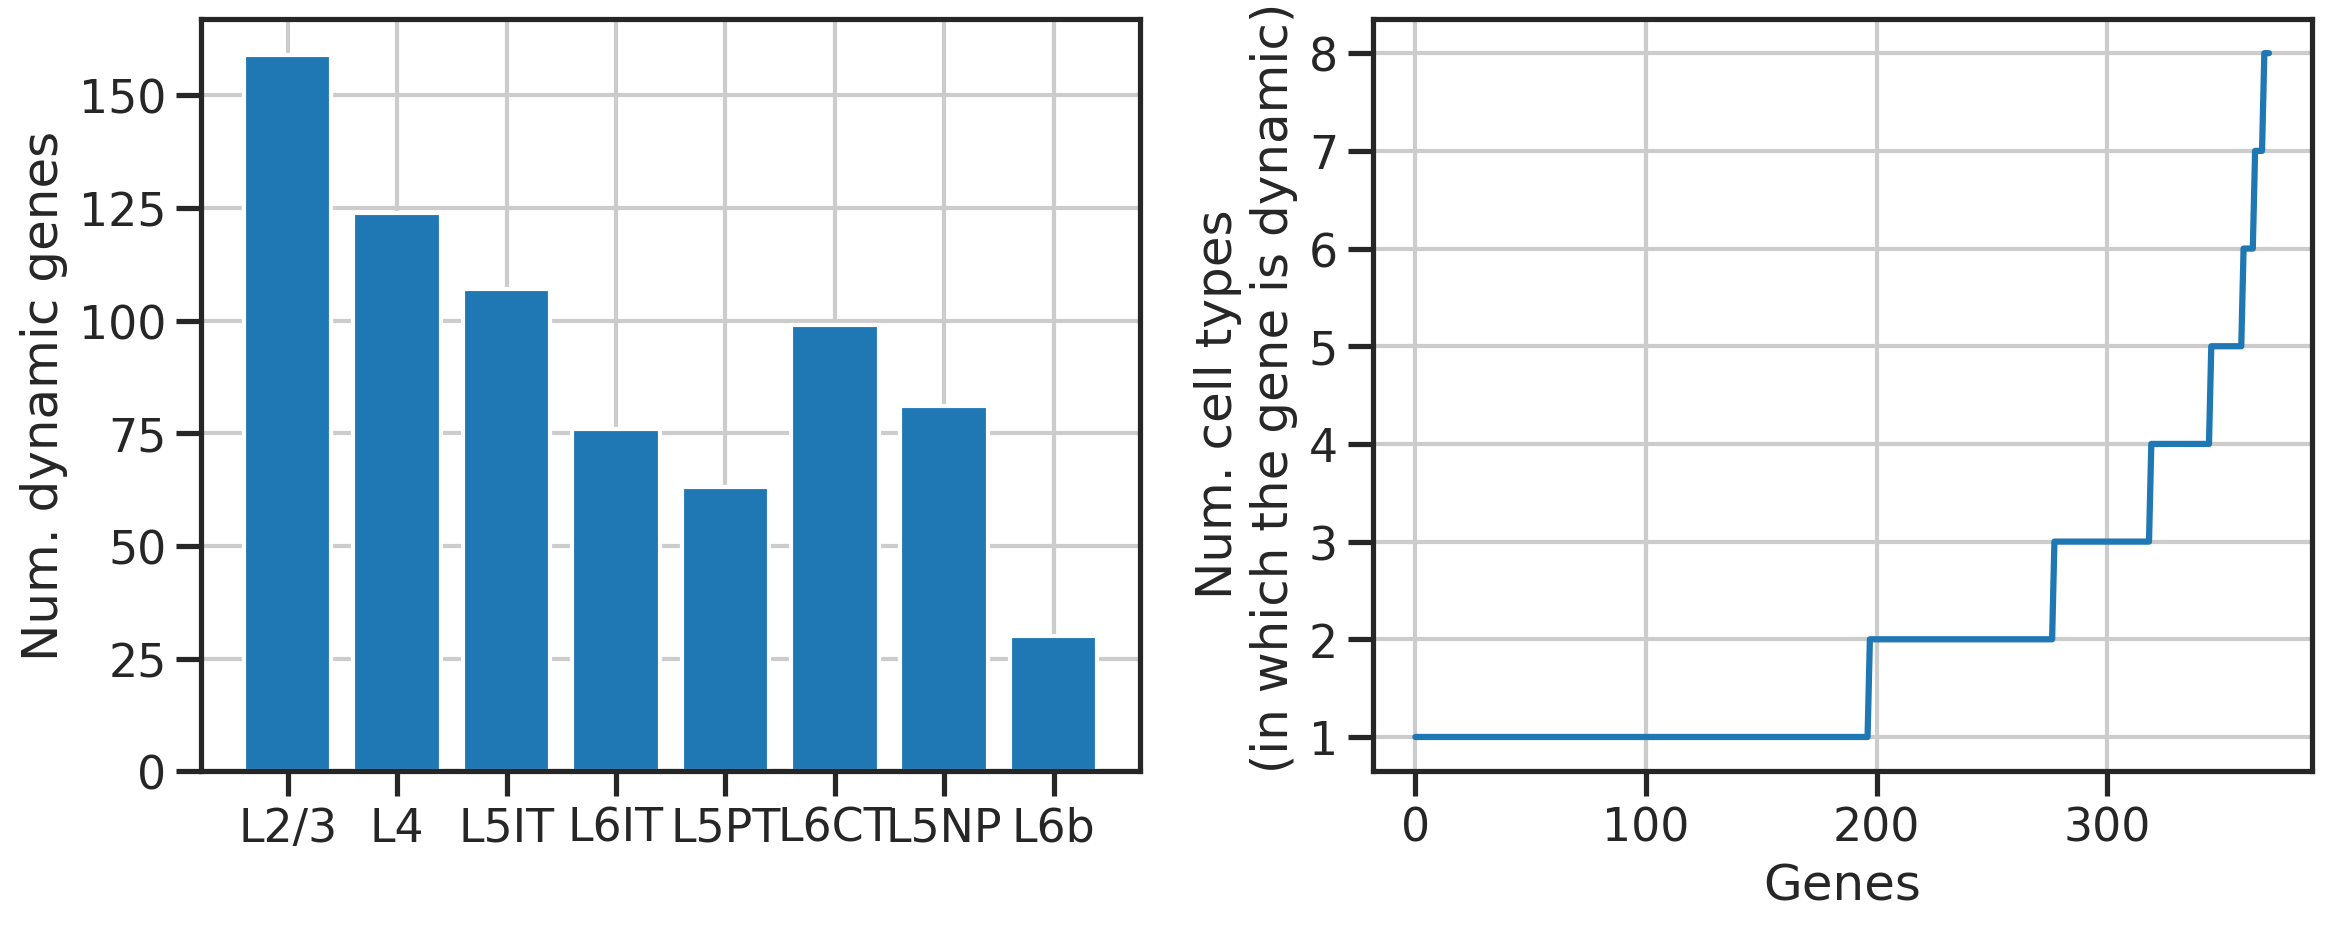

In [19]:
fig, axs = plt.subplots(1,2,figsize=(6*2,5))
ax = axs[0]
ax.bar(np.arange(8), c_hits)
ax.set_xticks(np.arange(8))
ax.set_xticklabels(xclsts_sel)
ax.set_ylabel('Num. dynamic genes')

ax = axs[1]
ax.plot(np.sort(g_hits[g_hits>0]))
ax.set_yticks(np.arange(1,8+1))
ax.set_xlabel('Genes')
ax.set_ylabel('Num. cell types \n (in which the gene is dynamic)')
fig.tight_layout()
plt.show()


# Specifics
- 1 gene in 1 cell type

In [20]:
ts = [8,14,17,21,28,38]
tsdup = np.repeat(ts,2)

In [21]:
hits, hits.shape, pbulks.shape

(array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 (8, 53801),
 (6, 2, 8, 53801))

In [22]:
# L2/3
celltype_idx = 0
celltype_name = xclsts_sel[celltype_idx]
nums = pbulks[:,:,celltype_idx, hits[celltype_idx]]
glbl = genes[hits[celltype_idx]]

nums.shape, glbl.shape

((6, 2, 159), (159,))

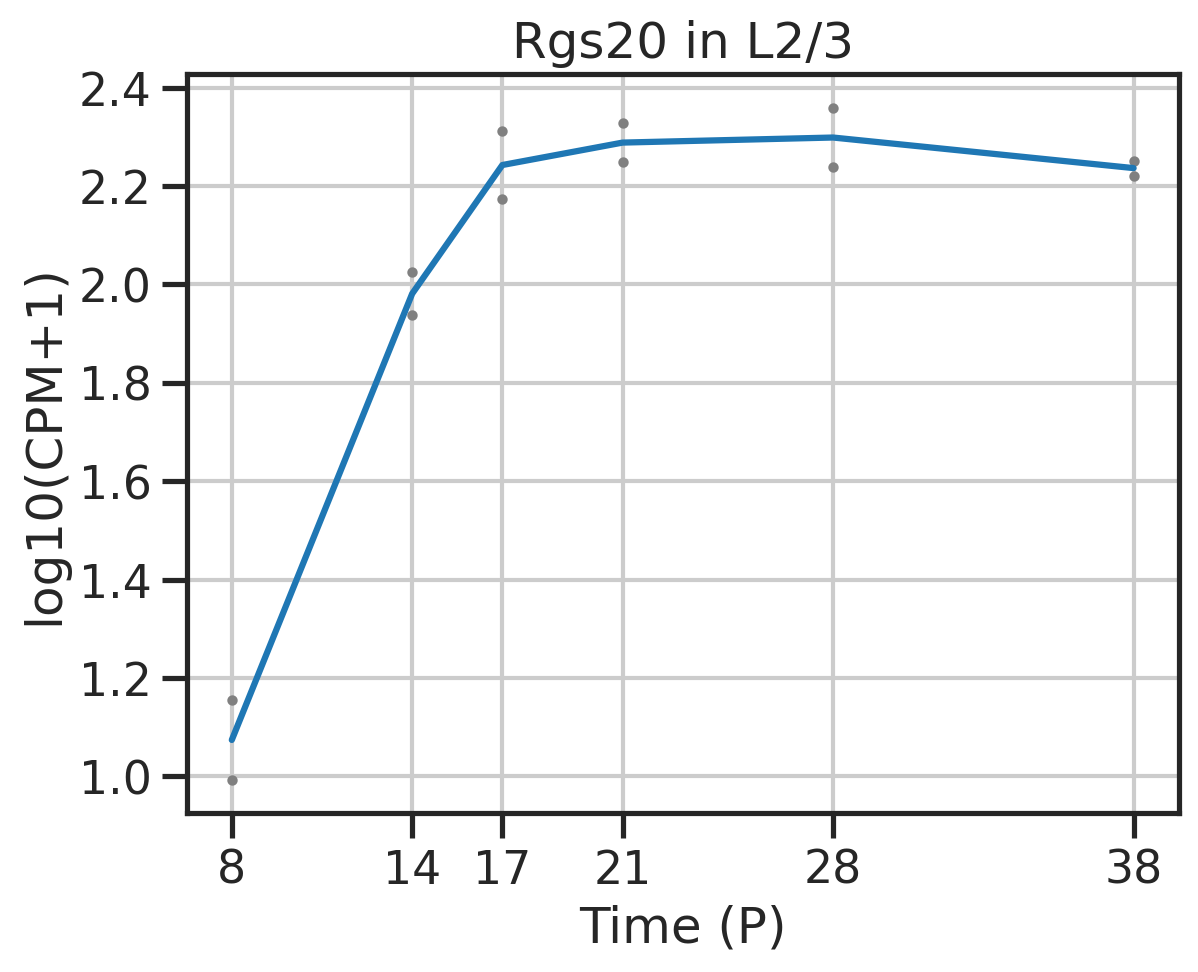

In [23]:
glbl_idx = 0

gene_name = glbl[glbl_idx]
nums_for_one = nums[:,:,glbl_idx]
nums_for_one_mean = np.mean(nums_for_one, axis=1)

fig, ax = plt.subplots()
ax.set_title(f"{gene_name} in {celltype_name}")
ax.scatter(tsdup, nums_for_one.ravel(), color='gray', s=5)
ax.plot(ts, nums_for_one_mean)
ax.set_xticks(ts)
ax.set_ylabel("log10(CPM+1)")
ax.set_xlabel("Time (P)")
plt.show()

# Slice1
- All genes in 1 cell type

In [24]:
hits, hits.shape, pbulks.shape

(array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 (8, 53801),
 (6, 2, 8, 53801))

In [25]:
# L2/3
celltype_idx = 0
celltype_name = xclsts_sel[celltype_idx]
glbl = genes[hits[celltype_idx]]
pb1csub = pbulks[:,:,celltype_idx, hits[celltype_idx]]
pb1csub_logfc = pb1csub - np.mean(pb1csub, axis=(0,1))

pb1csub = merge_first_few_dims(pb1csub).T
pb1csub_logfc = merge_first_few_dims(pb1csub_logfc).T 
rowidx = basicu.order_by_hc(pb1csub)
pb1csub.shape, glbl.shape

((159, 12), (159,))

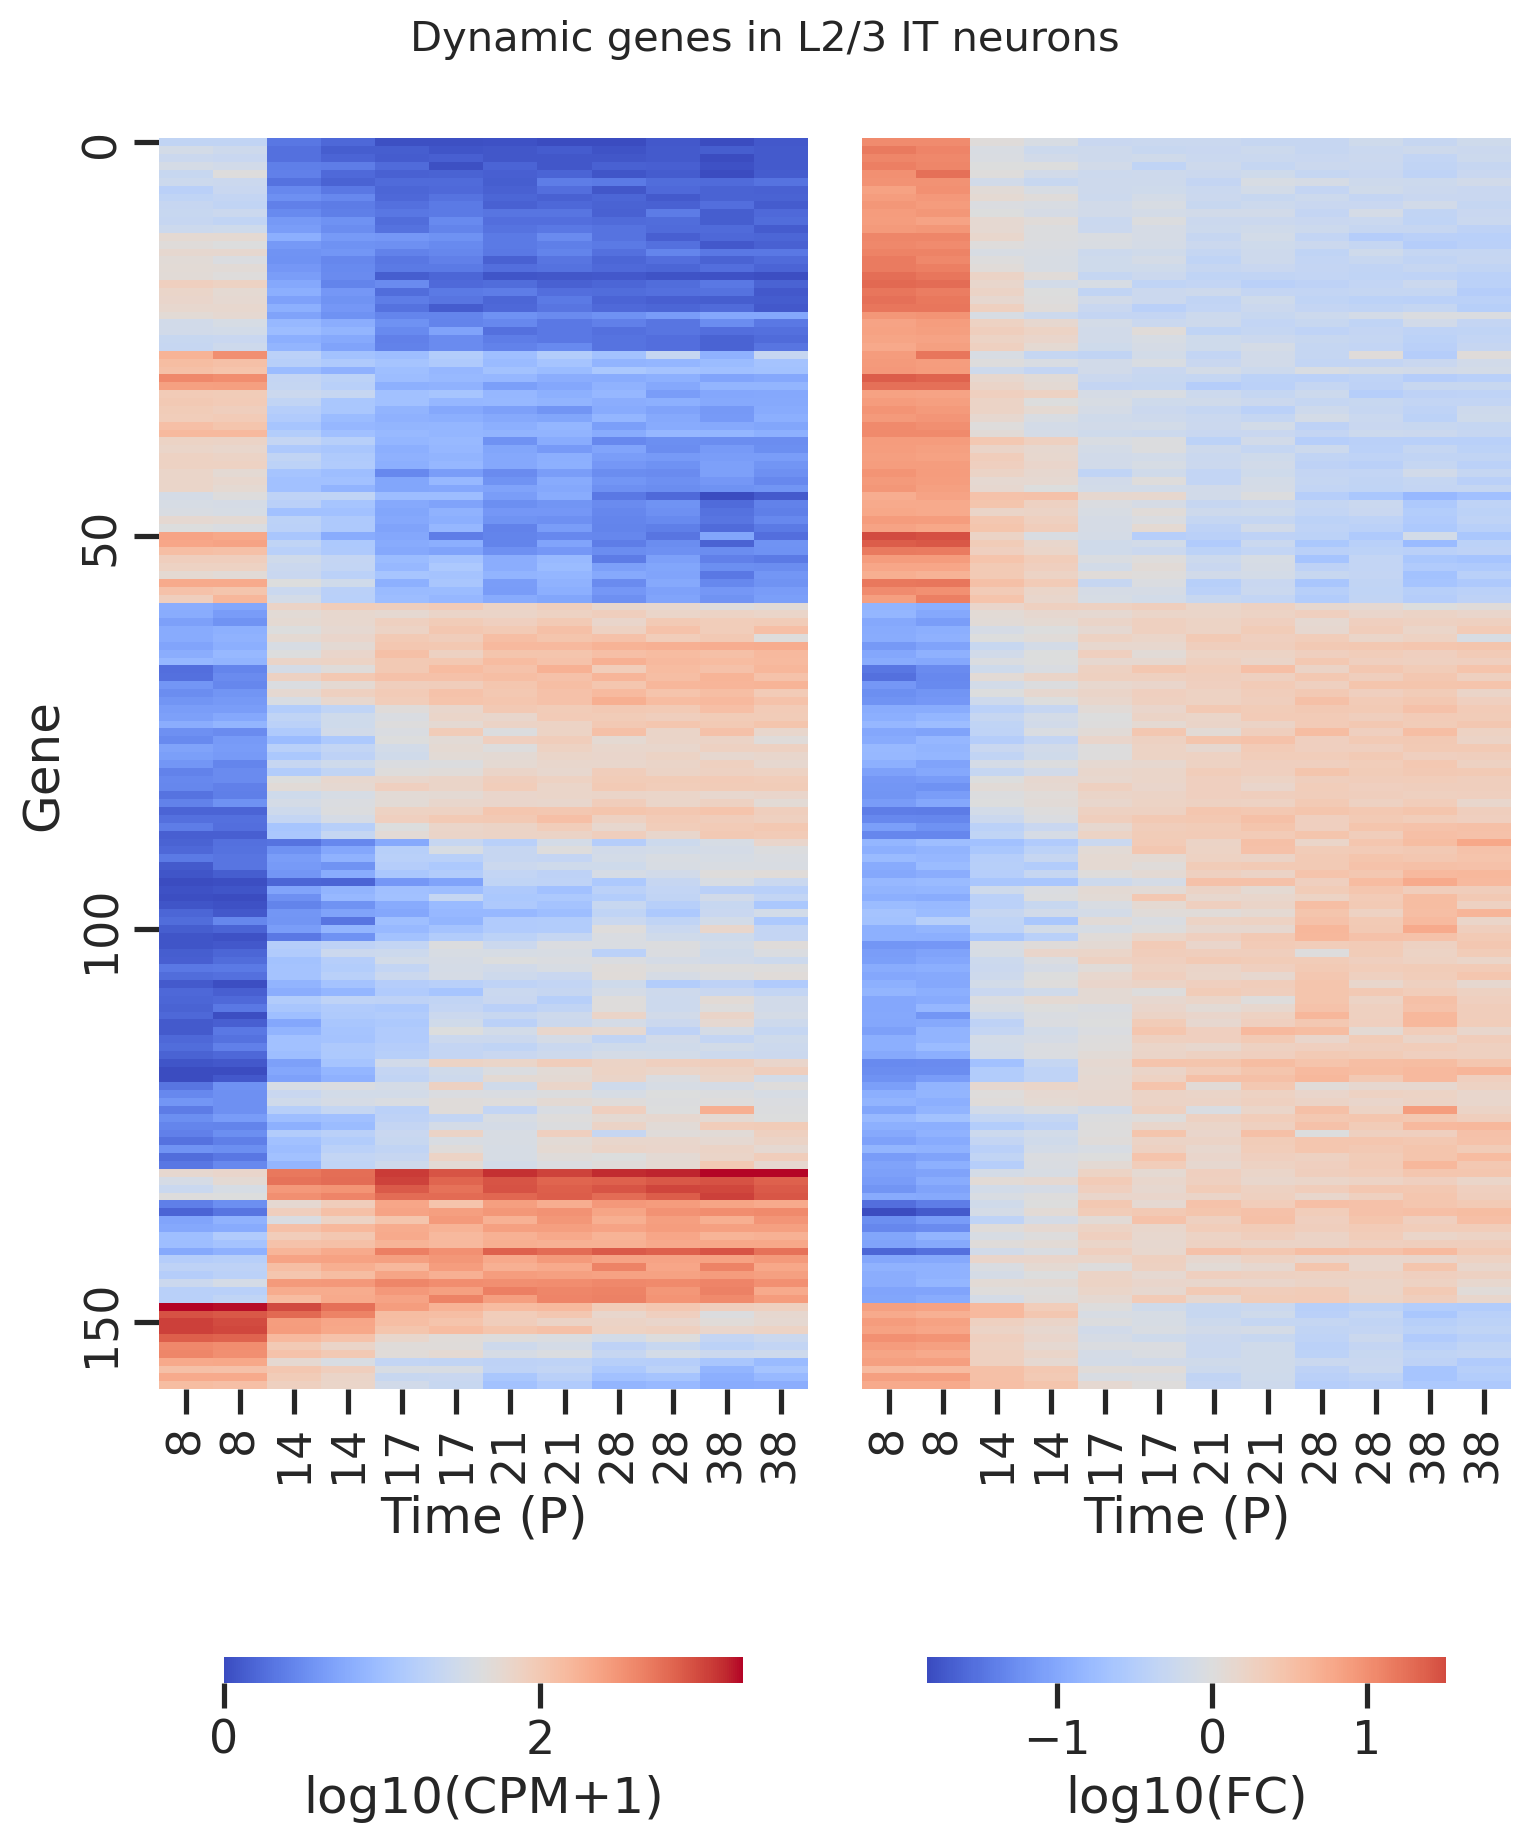

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(2*4,10))
fig.suptitle('Dynamic genes in L2/3 IT neurons', fontsize=15)

ax = axs[0]
sns.heatmap(pb1csub[rowidx],
            yticklabels=50,
            xticklabels=tsdup,
            cmap='coolwarm', 
            cbar_kws=dict(location='bottom', shrink=0.8, label='log10(CPM+1)'),
            ax=ax,
           )
ax.set_xlabel('Time (P)')
ax.set_ylabel('Gene')

ax = axs[1]
sns.heatmap(pb1csub_logfc[rowidx],
            yticklabels=False,
            xticklabels=tsdup,
            cmap='coolwarm', 
            cbar_kws=dict(location='bottom', shrink=0.8, label='log10(FC)'),
            center=0,
            ax=ax,
           )
ax.set_xlabel('Time (P)')
# ax.set_ylabel('Gene')

fig.tight_layout()
plt.show()

# Slice2
- a few genes in all 8 cell type

In [27]:
cond_sel = g_hits>=6
genes_shared = genes[cond_sel]
pbulks_shared = pbulks[:,:,:,cond_sel]
pbulks_shared.shape, genes_shared

((6, 2, 8, 12),
 array(['Ier5', 'Kcnmb2', 'Plppr1', 'Vgf', 'Slc29a4', '1700016P03Rik',
        'Nrn1', 'Vcan', 'Ankrd33b', 'Arc', 'Aifm3', 'Egr1'], dtype=object))

(12, 12)


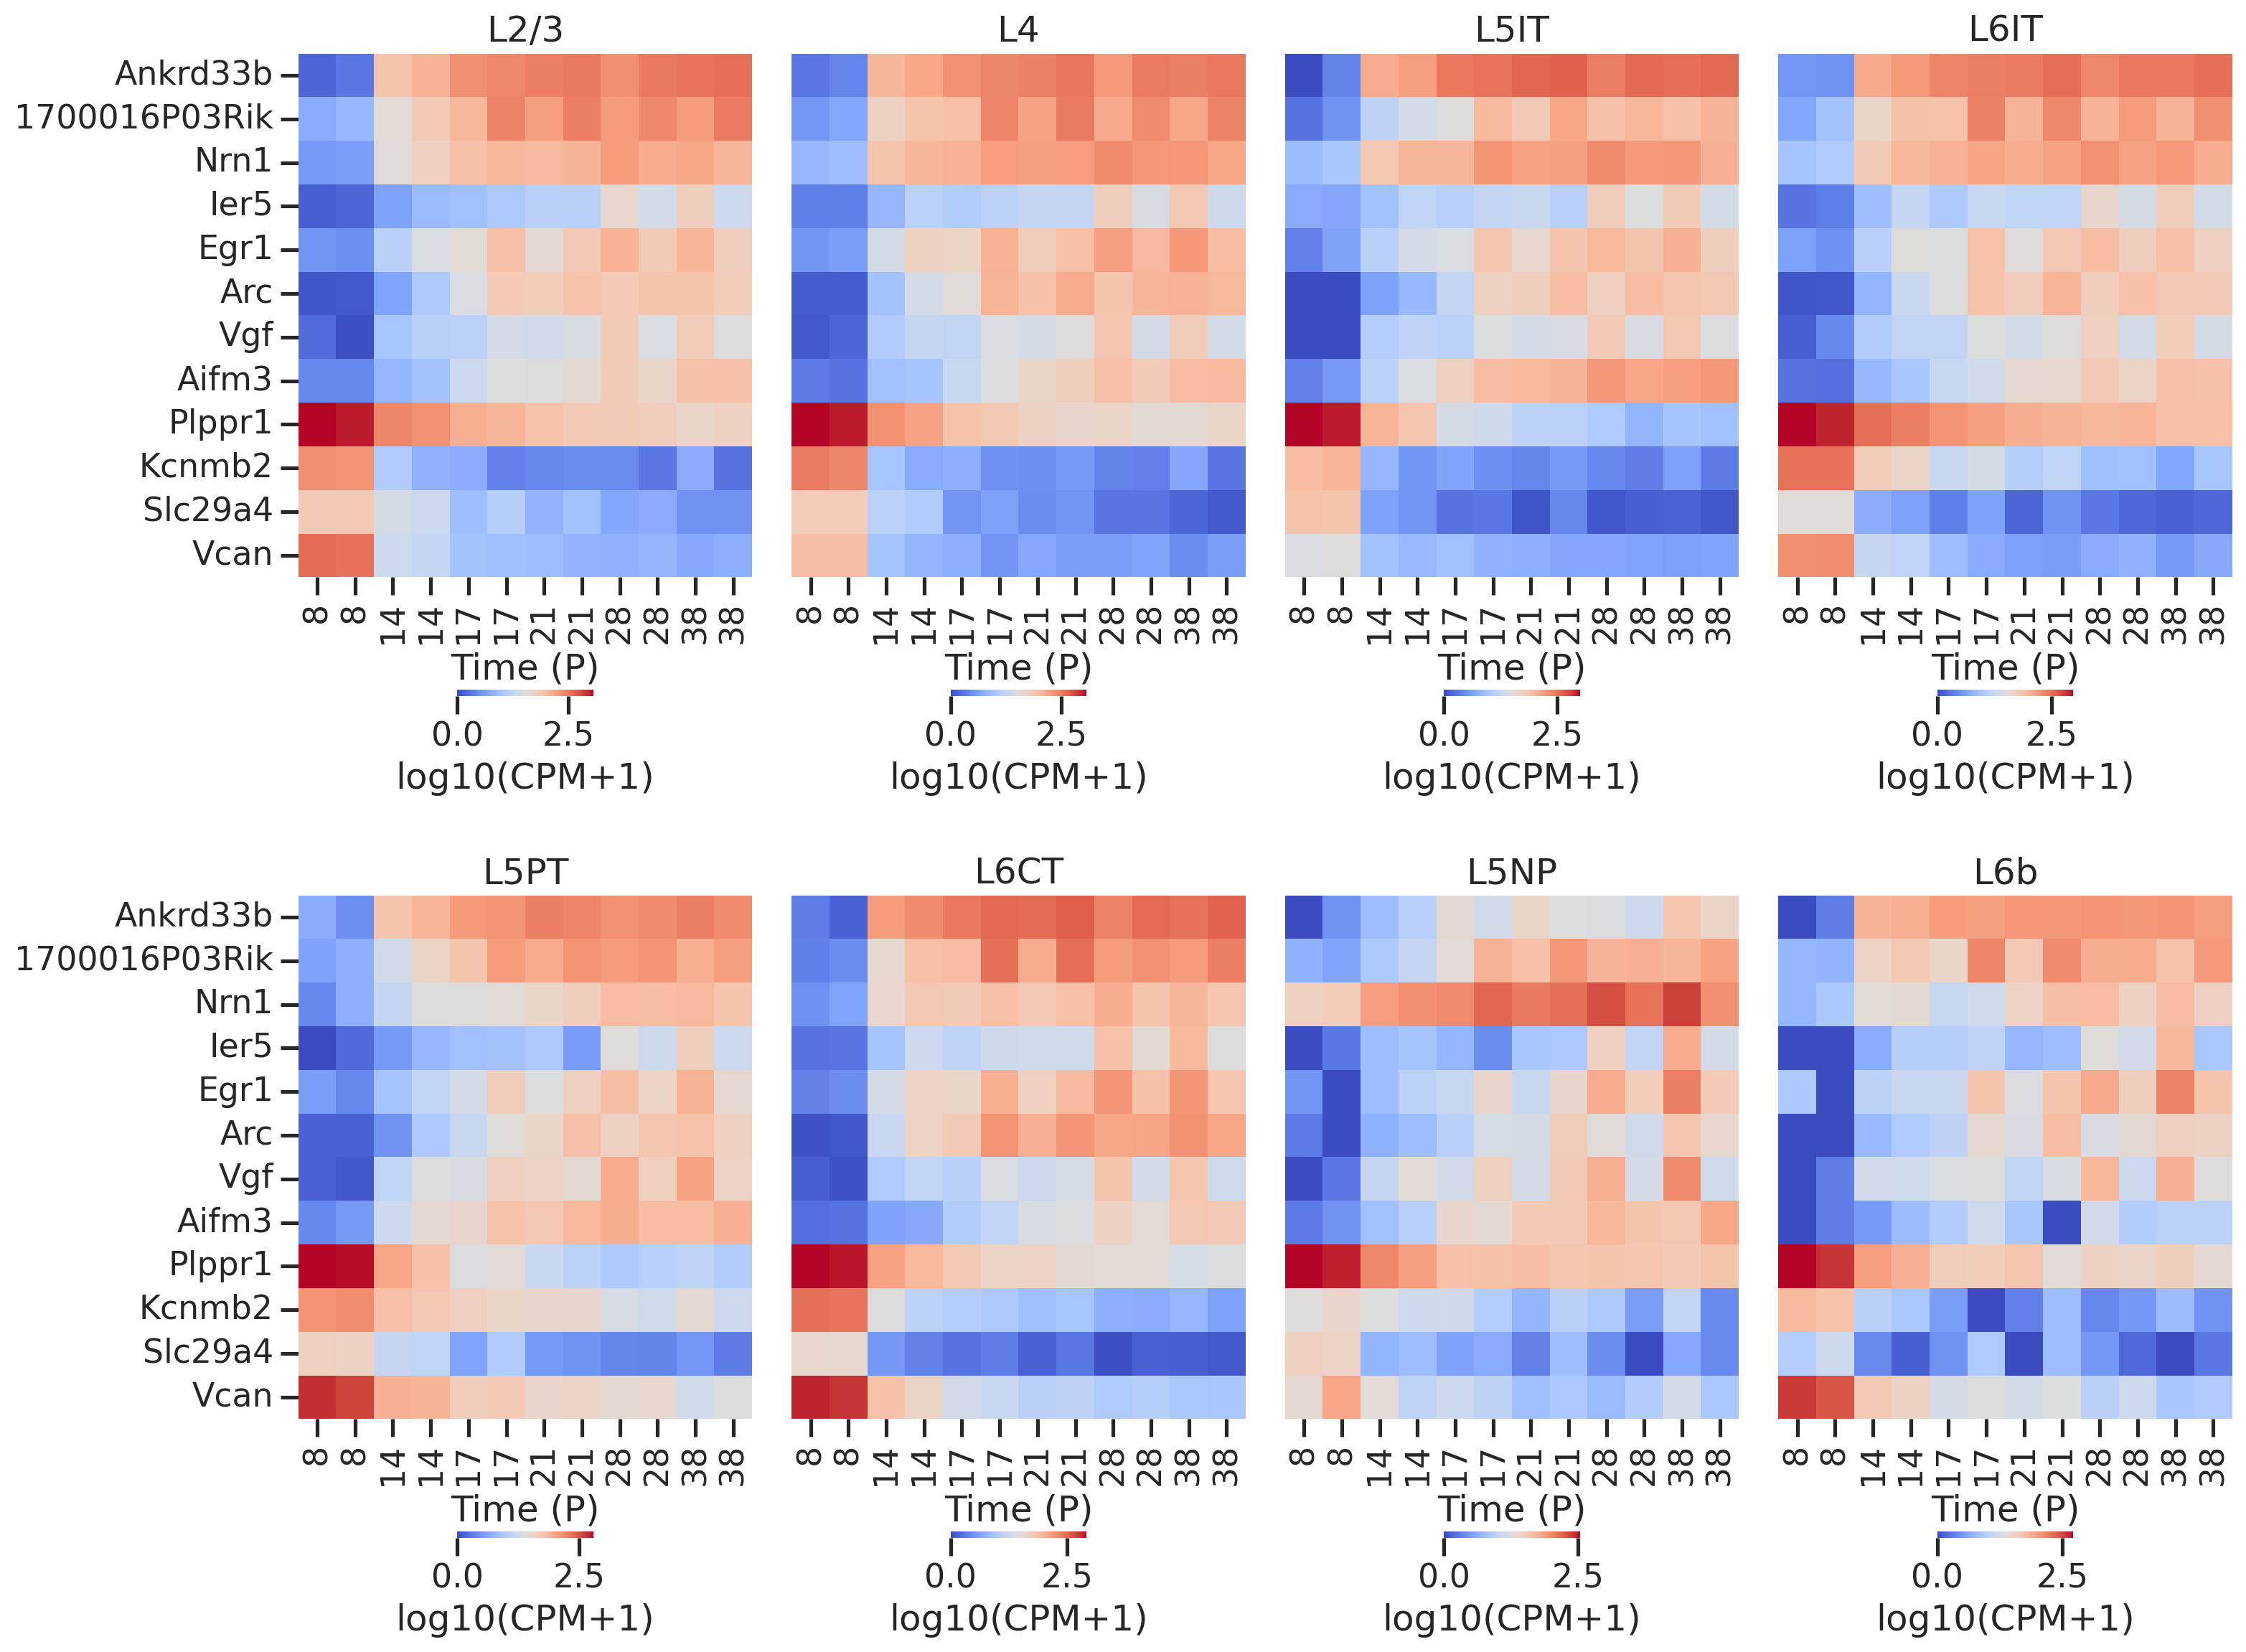

In [28]:
mat0 = pbulks_shared[:,:,0,:]
mat0 = merge_first_few_dims(mat0).T
print(mat0.shape)
rowidx = basicu.order_by_hc(mat0)

fig, axs = plt.subplots(2, 4, figsize=(4*4,2*6))
# fig.suptitle('Dynamic genes in L2/3 IT neurons', fontsize=15)
for i in range(8):
    ax = axs.flat[i]
    ax.set_title(xclsts_sel[i])
    if i % 4 == 0:
        yticklabels = genes_shared[rowidx]
        ax.set_ylabel('Gene')
    else:
        yticklabels = False
        
    mat = pbulks_shared[:,:,i,:]
    mat = merge_first_few_dims(mat).T
    
    sns.heatmap(mat[rowidx], #[:,colidx], 
                yticklabels=yticklabels,
                xticklabels=tsdup,
                cmap='coolwarm', 
                cbar_kws=dict(location='bottom', shrink=0.3, label='log10(CPM+1)'),
                vmin=0,
                ax=ax,
               )
    ax.set_xlabel('Time (P)')

fig.tight_layout()
plt.show()

# Slice2-2
- a few genes in all 8 cell type

In [29]:
cond_sel = np.logical_and(np.all(hits[:4], axis=0), np.all(~hits[4:], axis=0))
genes_shared = genes[cond_sel]
pbulks_shared = pbulks[:,:,:,cond_sel]
pbulks_shared.shape, genes_shared

((6, 2, 8, 5),
 array(['Col19a1', 'Pcsk6', 'Aldh1l2', 'Exph5', 'Mei1'], dtype=object))

(5, 12)


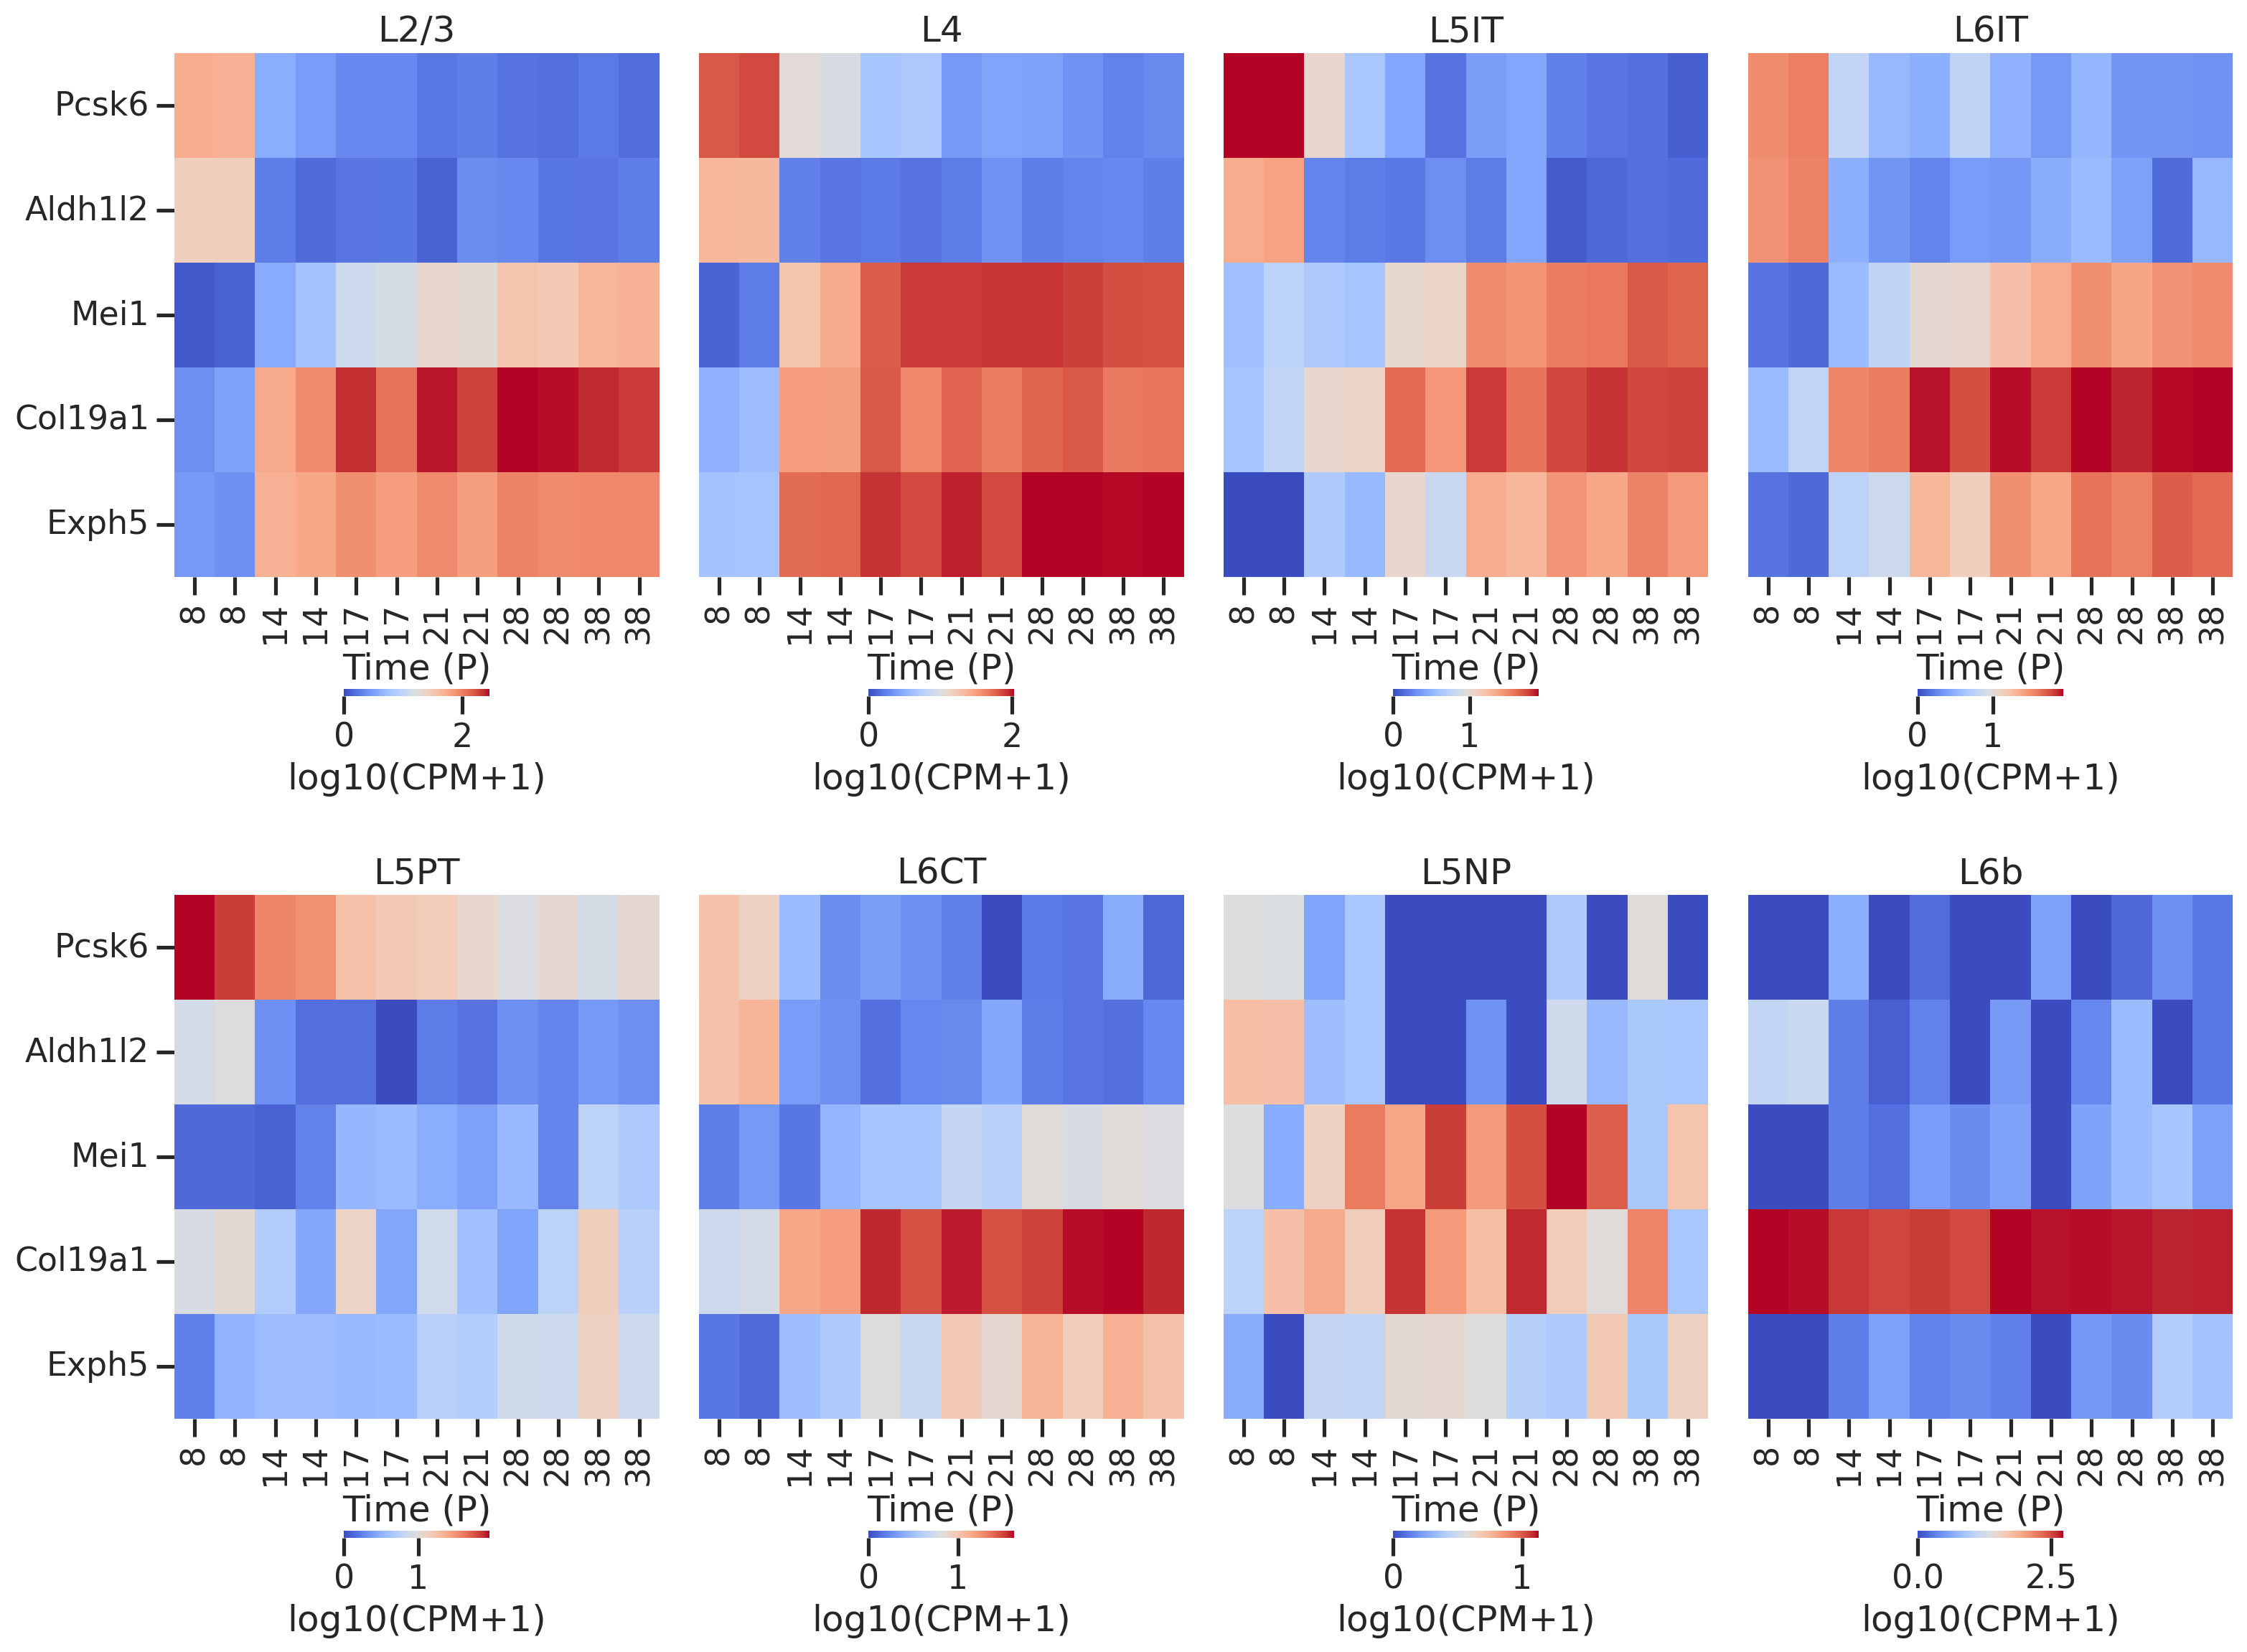

In [30]:
mat0 = pbulks_shared[:,:,0,:]
mat0 = merge_first_few_dims(mat0).T
print(mat0.shape)
rowidx = basicu.order_by_hc(mat0)

fig, axs = plt.subplots(2, 4, figsize=(4*4,2*6))
# fig.suptitle('Dynamic genes in L2/3 IT neurons', fontsize=15)
for i in range(8):
    ax = axs.flat[i]
    ax.set_title(xclsts_sel[i])
    if i % 4 == 0:
        yticklabels = genes_shared[rowidx]
        ax.set_ylabel('Gene')
    else:
        yticklabels = False
        
    mat = pbulks_shared[:,:,i,:]
    mat = merge_first_few_dims(mat).T
    
    sns.heatmap(mat[rowidx], #[:,colidx], 
                yticklabels=yticklabels,
                xticklabels=tsdup,
                cmap='coolwarm', 
                cbar_kws=dict(location='bottom', shrink=0.3, label='log10(CPM+1)'),
                vmin=0,
                ax=ax,
               )
    ax.set_xlabel('Time (P)')

fig.tight_layout()
plt.show()

# Plot specific genes (double check)

In [53]:
hits, hits.shape, pbulks.shape

(array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 (8, 53801),
 (6, 2, 8, 53801))

24583 (6, 2, 8)


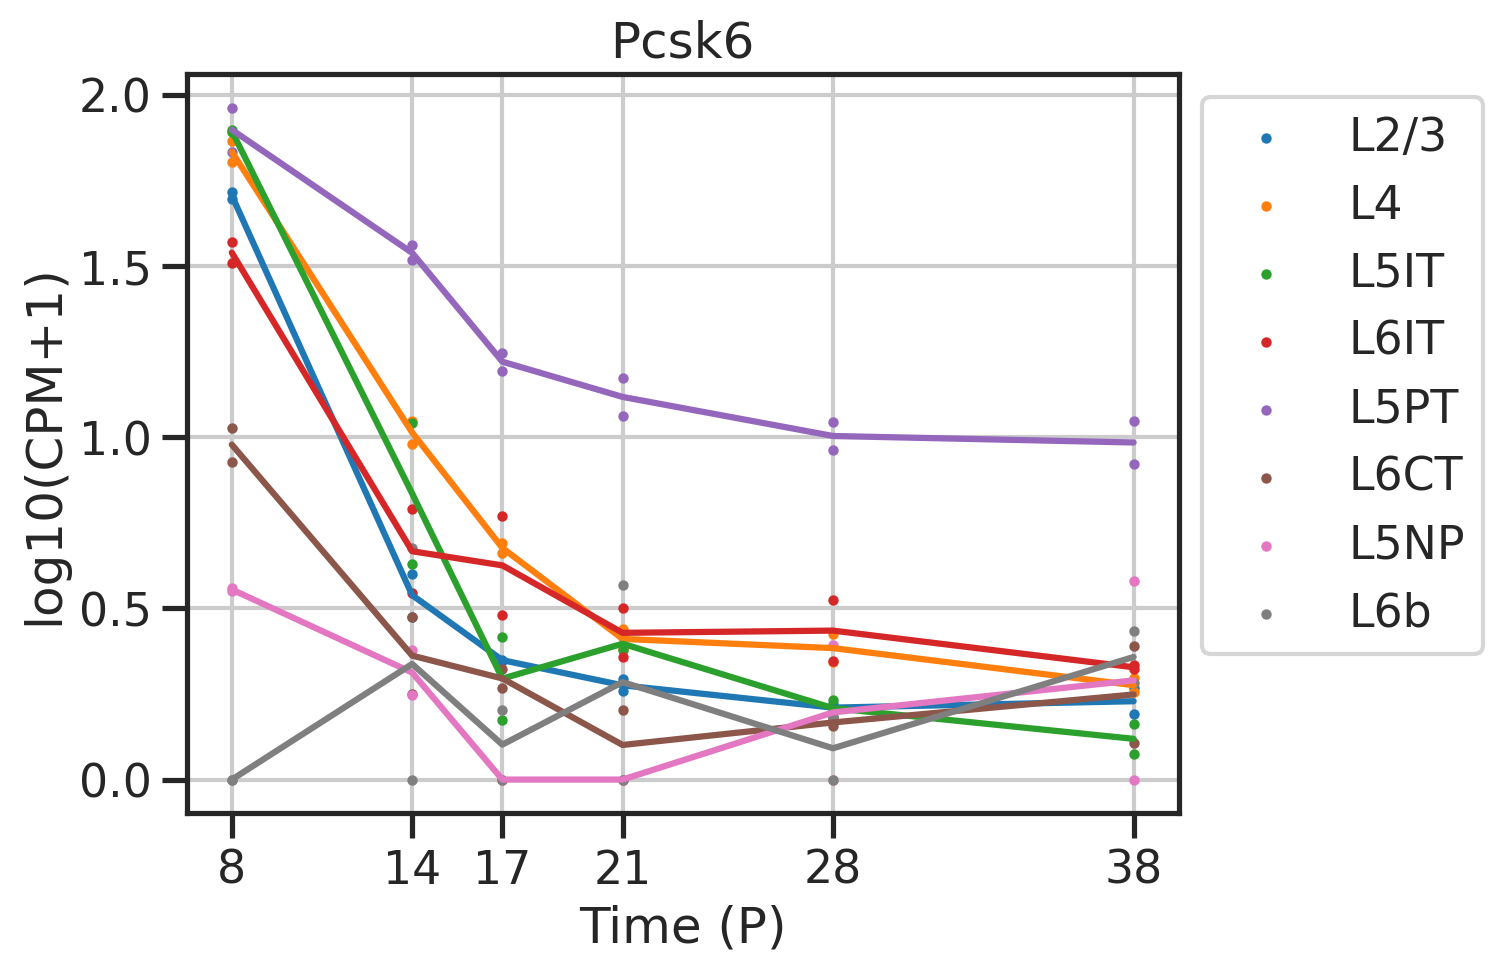

In [58]:
gene_name = 'Pcsk6' 
gidx = np.arange(len(genes))[genes==gene_name][0]
pb1g = pbulks[:,:,:,gidx]
print(gidx, pb1g.shape)

fig, ax = plt.subplots()
for i in range(8):
    nums_for_one = pb1g[:,:,i]
    nums_for_one_mean = np.mean(nums_for_one, axis=1)

    ax.set_title(f"{gene_name}")
    ax.plot(ts, nums_for_one_mean)
    ax.scatter(tsdup, nums_for_one.ravel(), s=5, label=xclsts_sel[i])
    
ax.set_xticks(ts)
ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel("log10(CPM+1)")
ax.set_xlabel("Time (P)")
plt.show()

28322 (6, 2, 8)


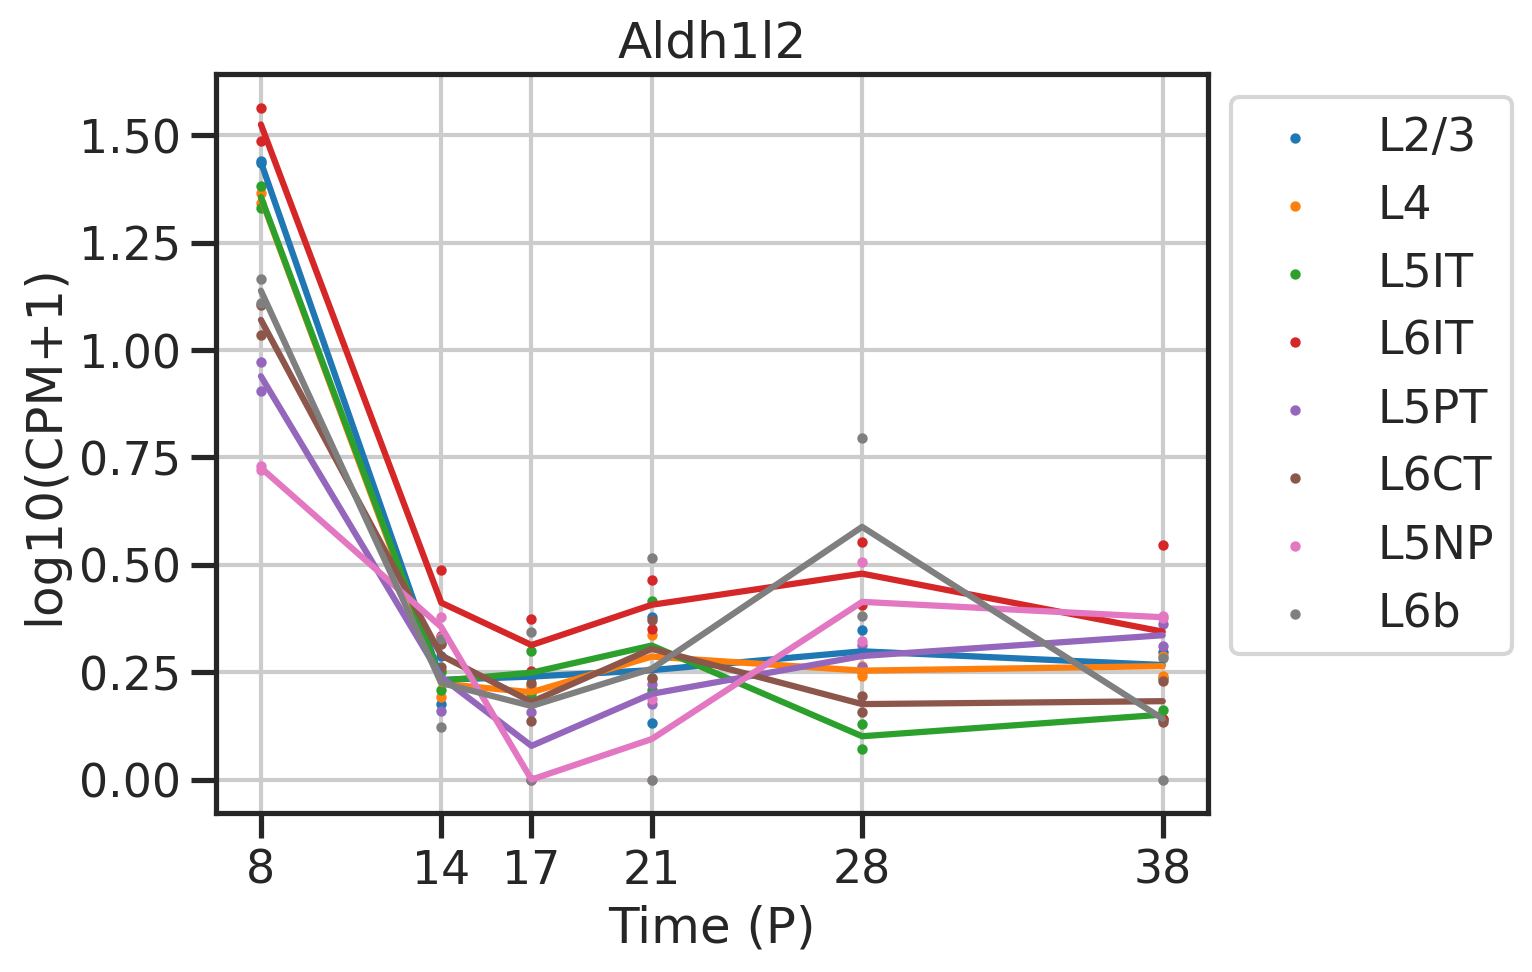

In [59]:
gene_name = 'Aldh1l2' 
gidx = np.arange(len(genes))[genes==gene_name][0]
pb1g = pbulks[:,:,:,gidx]
print(gidx, pb1g.shape)

fig, ax = plt.subplots()
for i in range(8):
    nums_for_one = pb1g[:,:,i]
    nums_for_one_mean = np.mean(nums_for_one, axis=1)

    ax.set_title(f"{gene_name}")
    ax.plot(ts, nums_for_one_mean)
    ax.scatter(tsdup, nums_for_one.ravel(), s=5, label=xclsts_sel[i])
    
ax.set_xticks(ts)
ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel("log10(CPM+1)")
ax.set_xlabel("Time (P)")
plt.show()

46481 (6, 2, 8)


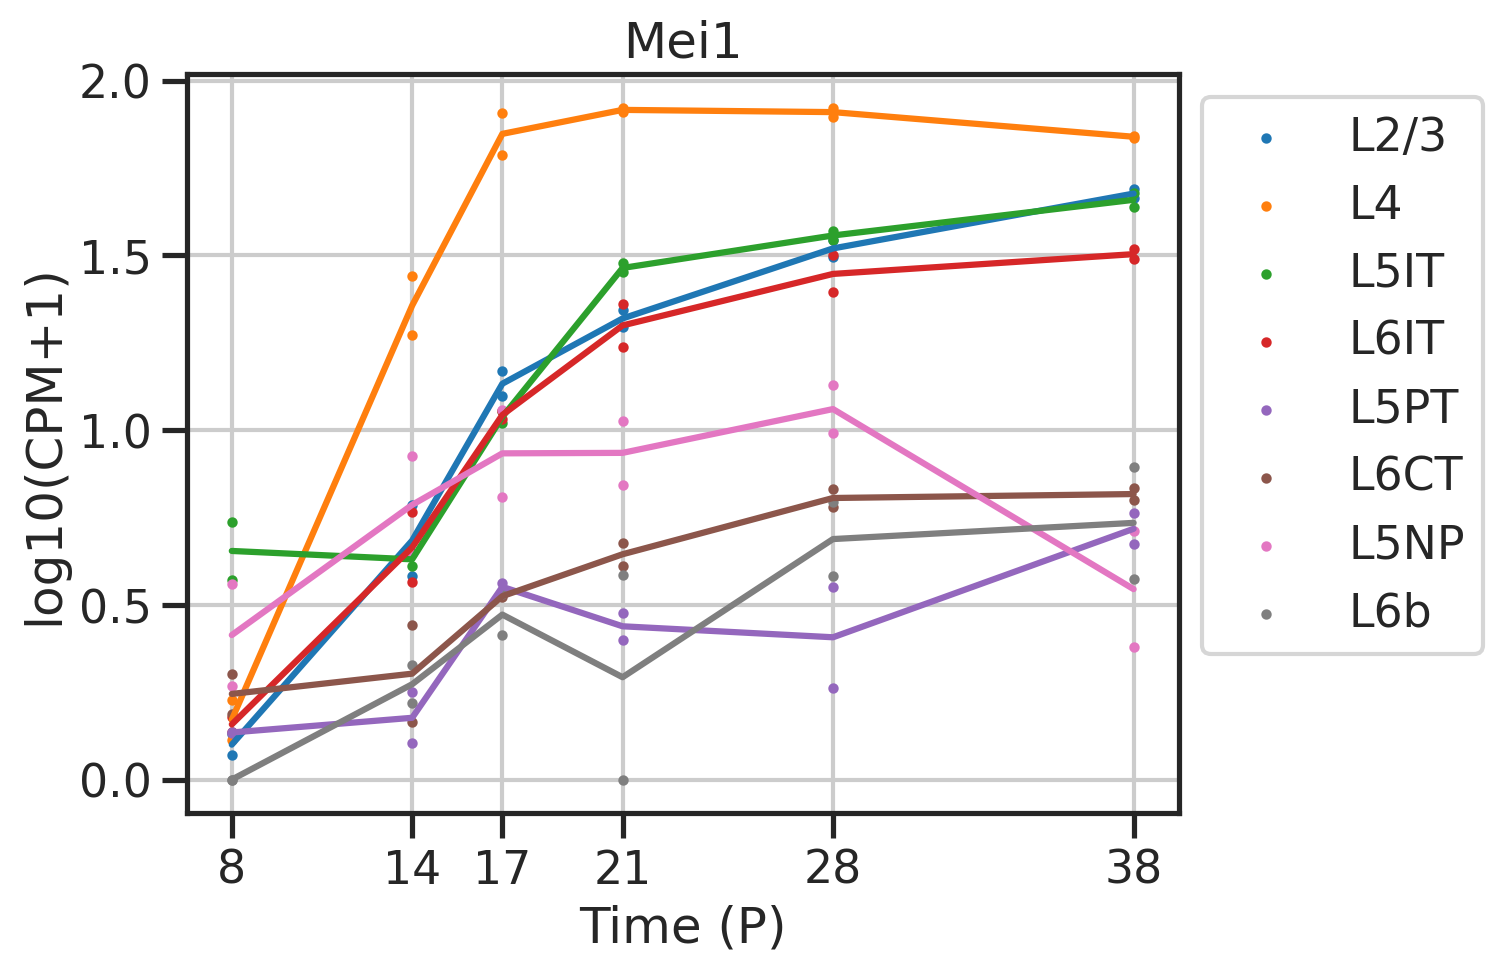

323 (6, 2, 8)


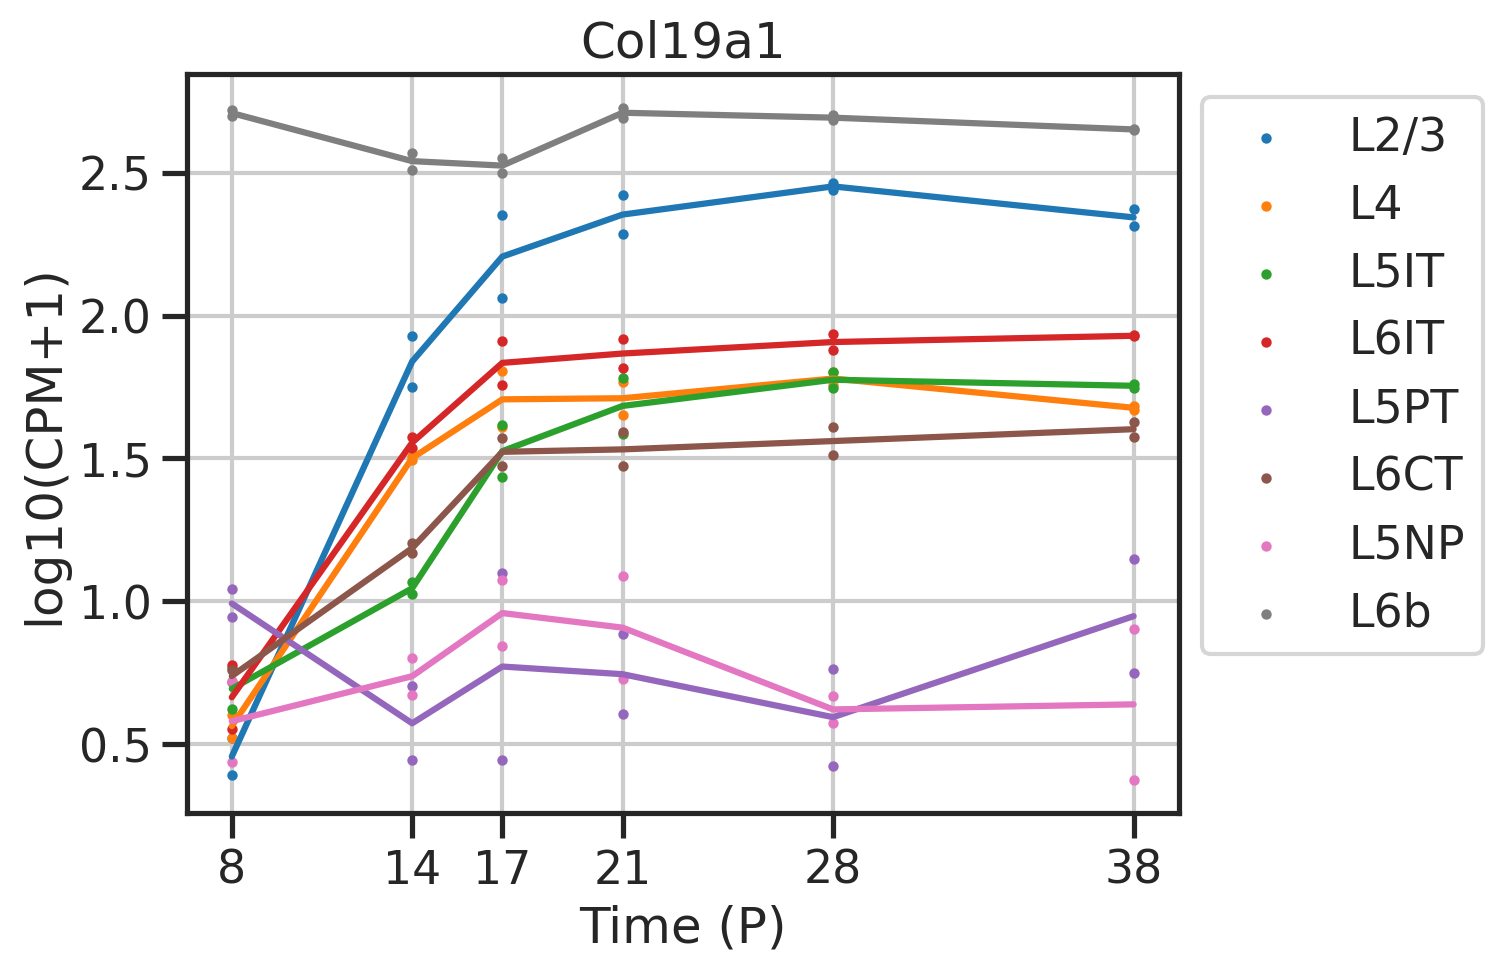

35587 (6, 2, 8)


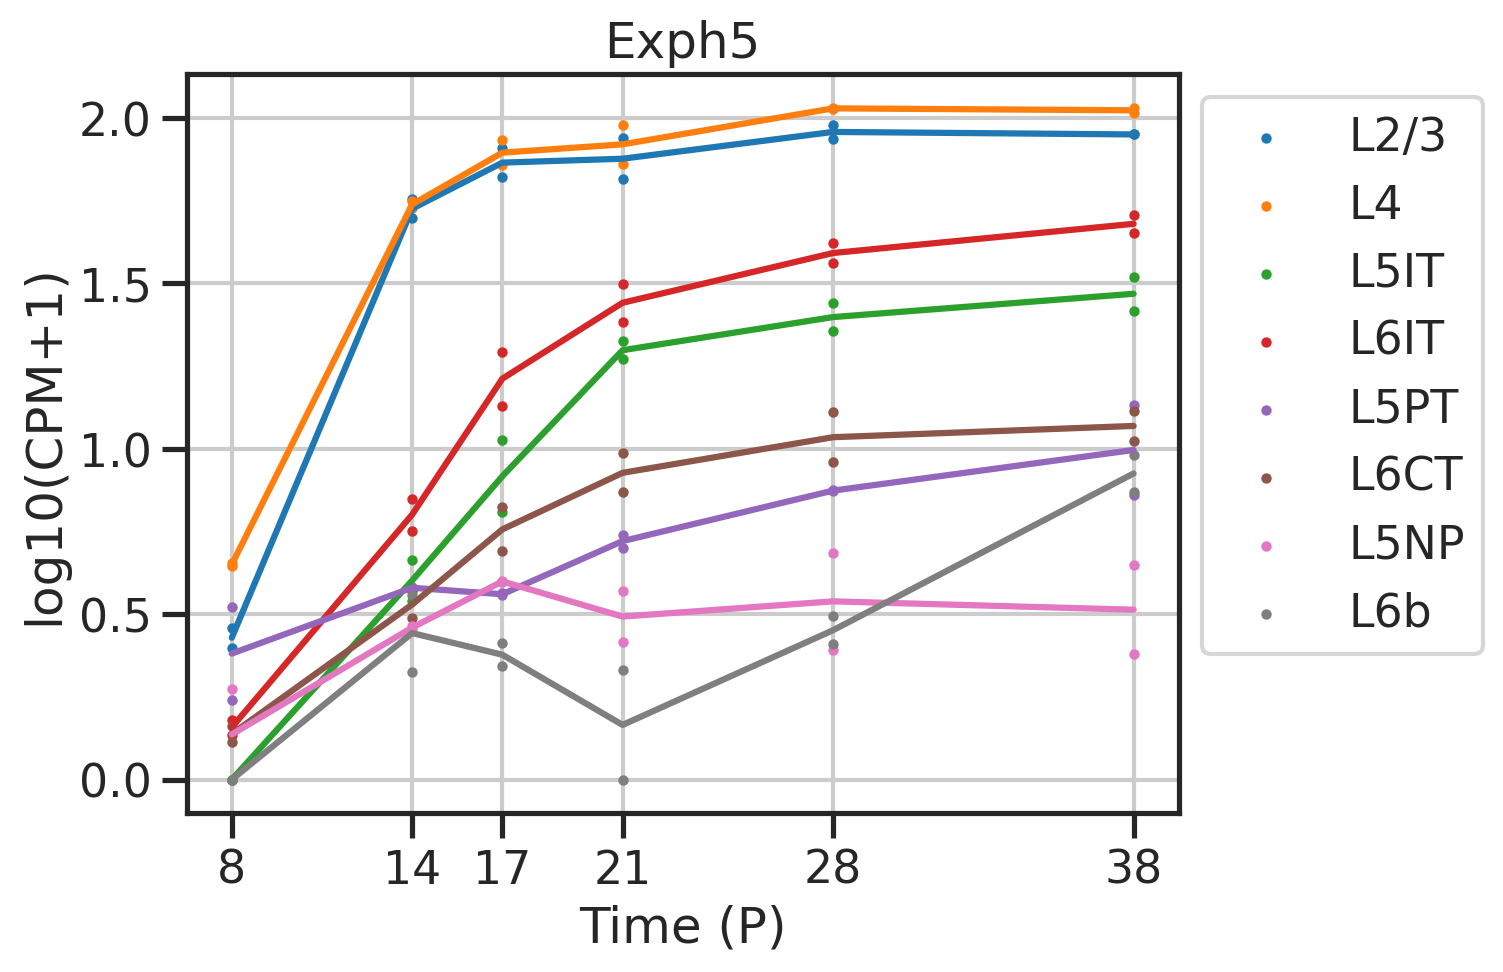

In [60]:
# gene_name = 'Mei' 
for gene_name in ['Mei1', 'Col19a1', 'Exph5']:
    gidx = np.arange(len(genes))[genes==gene_name][0]
    pb1g = pbulks[:,:,:,gidx]
    print(gidx, pb1g.shape)

    fig, ax = plt.subplots()
    for i in range(8):
        nums_for_one = pb1g[:,:,i]
        nums_for_one_mean = np.mean(nums_for_one, axis=1)

        ax.set_title(f"{gene_name}")
        ax.plot(ts, nums_for_one_mean)
        ax.scatter(tsdup, nums_for_one.ravel(), s=5, label=xclsts_sel[i])

    ax.set_xticks(ts)
    ax.legend(bbox_to_anchor=(1,1))
    ax.set_ylabel("log10(CPM+1)")
    ax.set_xlabel("Time (P)")
    plt.show()

13433 (6, 2, 8)


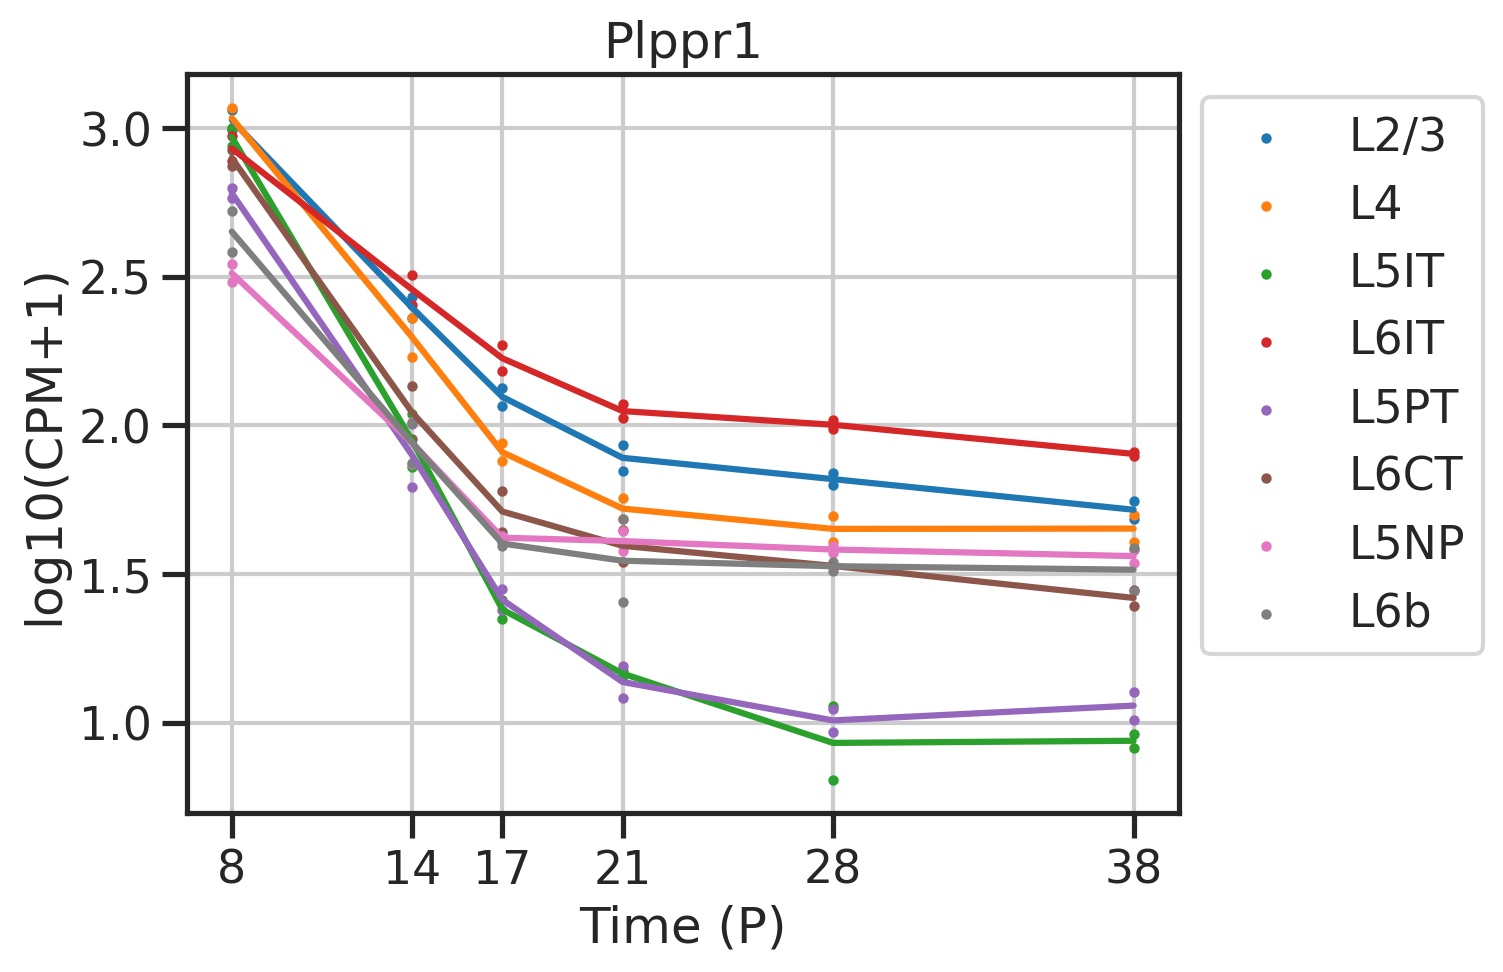

45570 (6, 2, 8)


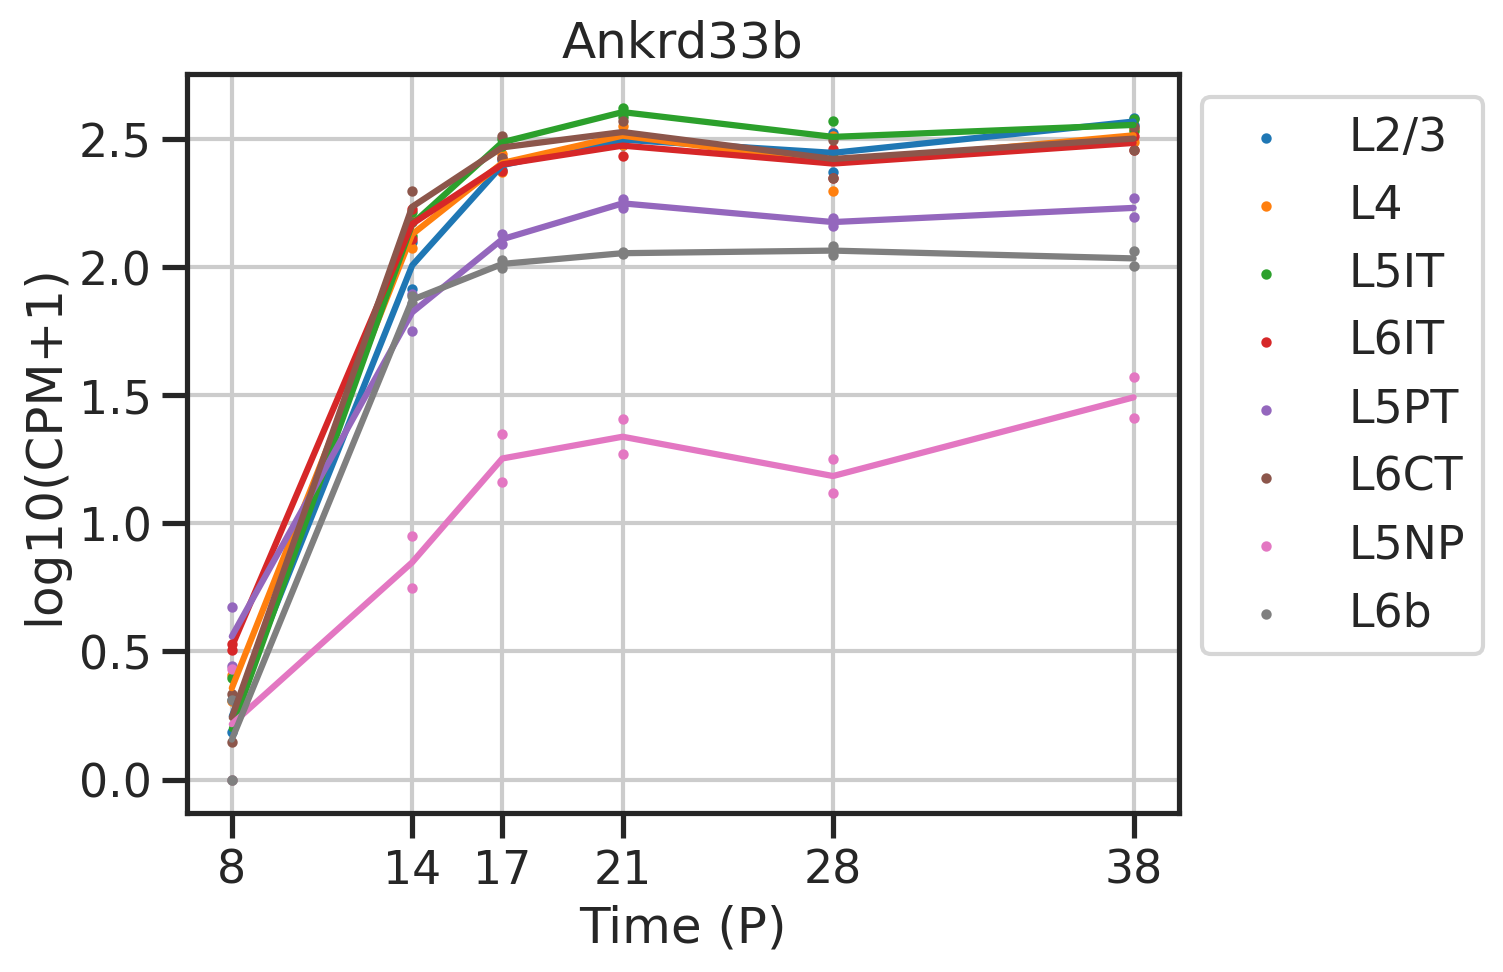

In [62]:
# gene_name = 'Mei' 
for gene_name in ['Plppr1', 'Ankrd33b',]:
    gidx = np.arange(len(genes))[genes==gene_name][0]
    pb1g = pbulks[:,:,:,gidx]
    print(gidx, pb1g.shape)

    fig, ax = plt.subplots()
    for i in range(8):
        nums_for_one = pb1g[:,:,i]
        nums_for_one_mean = np.mean(nums_for_one, axis=1)

        ax.set_title(f"{gene_name}")
        ax.plot(ts, nums_for_one_mean)
        ax.scatter(tsdup, nums_for_one.ravel(), s=5, label=xclsts_sel[i])

    ax.set_xticks(ts)
    ax.legend(bbox_to_anchor=(1,1))
    ax.set_ylabel("log10(CPM+1)")
    ax.set_xlabel("Time (P)")
    plt.show()

# Overlap with existing designs 